In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from collections import Counter
from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

import optuna

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [ ]:
tqdm.pandas()

sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.simplefilter('ignore')

import random
random.seed(42)

In [ ]:
from google.colab import drive
import pandas as pd


# Paths to your datasets
train_logs_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/train_logs.csv'
train_scores_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/train_scores.csv'
test_logs_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/test_logs.csv'
sample_submission_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/sample_submission.csv'

# Load the datasets
train_logs = pd.read_csv(train_logs_path)
train_scores = pd.read_csv(train_scores_path)
test_logs = pd.read_csv(test_logs_path)

ss_df = pd.read_csv(sample_submission_path)



In [ ]:
train_logs.shape, train_scores.shape, test_logs.shape, ss_df.shape

((8405898, 11), (2471, 2), (6, 11), (3, 2))

In [ ]:
train_logs.head()

id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1

In [ ]:
train_scores.head()

id  score
0  001519c8    3.5
1  0022f953    3.5
2  0042269b    6.0
3  0059420b    2.0
4  0075873a    4.0

In [ ]:
train_scores.describe()

score
count  2471.000000
mean      3.711251
std       1.024937
min       0.500000
25%       3.000000
50%       4.000000
75%       4.500000
max       6.000000

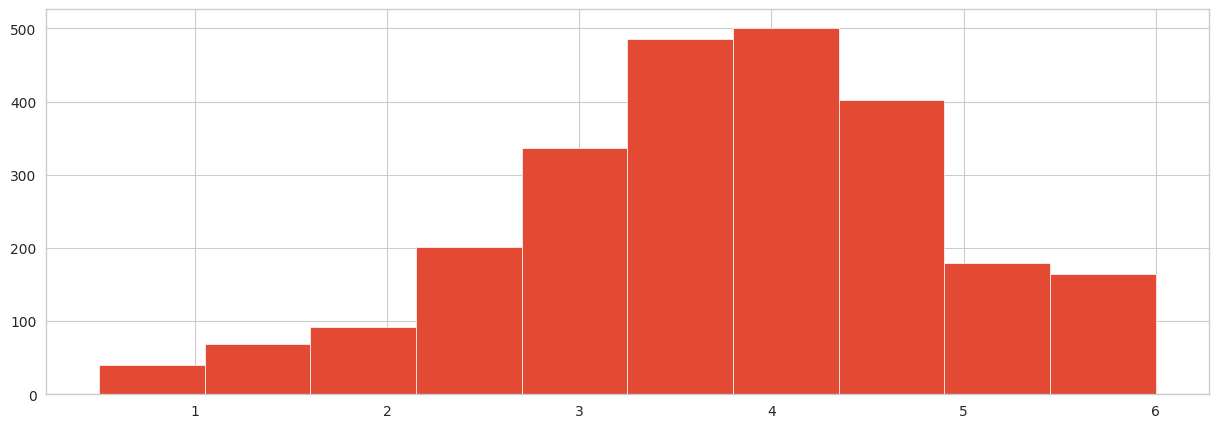

In [ ]:
plt.figure(figsize=(15, 5))
train_scores['score'].hist()
plt.show()

In [ ]:
train_scores['score'].value_counts()

score
4.0    501
3.5    486
4.5    402
3.0    336
2.5    201
5.0    179
5.5    128
2.0     92
1.5     69
6.0     37
1.0     35
0.5      5
Name: count, dtype: int64

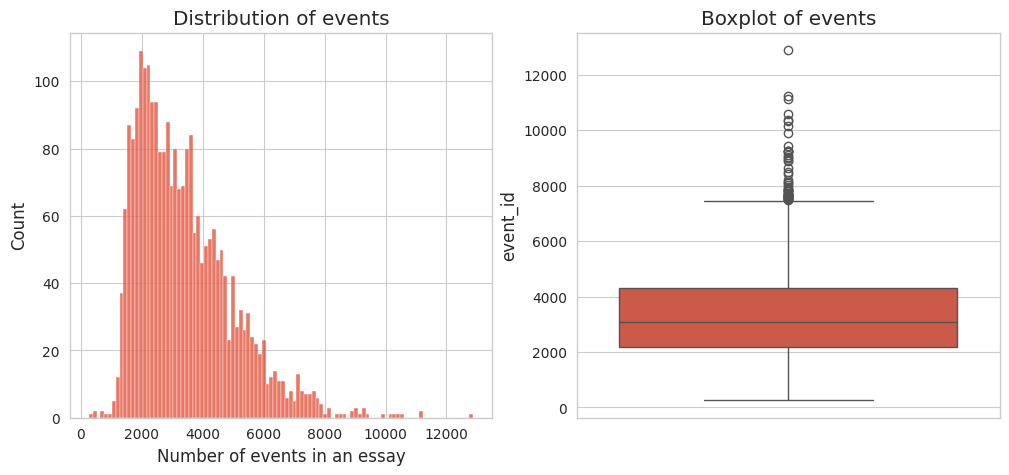

In [ ]:
event_stats = train_logs.groupby("id")['event_id'].count()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of events')
ax[0].set_xlabel('Number of events in an essay')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of events')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

In [ ]:
event_stats.describe()

count     2471.000000
mean      3401.820316
std       1578.850387
min        262.000000
25%       2193.500000
50%       3082.000000
75%       4301.000000
max      12876.000000
Name: event_id, dtype: float64

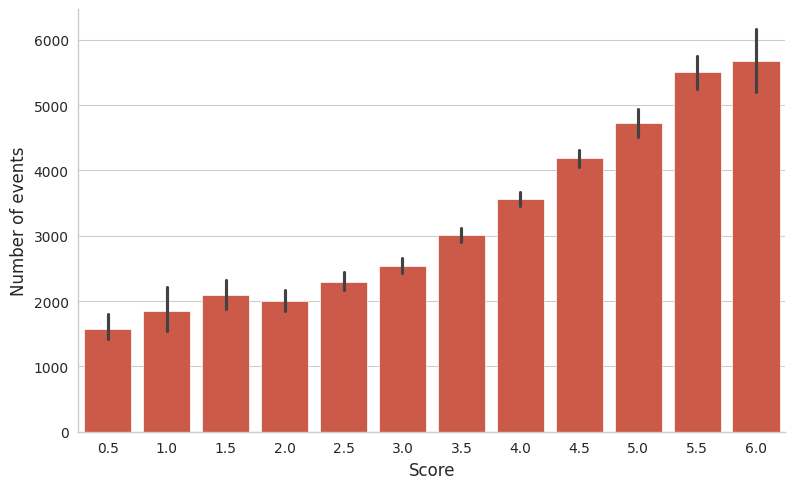

In [ ]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of events', fontsize=12)
plt.show()

In [ ]:
tmp = train_logs["up_time"] - train_logs["down_time"]
results = (tmp == train_logs["action_time"])
results.value_counts()

True    8405898
Name: count, dtype: int64

In [ ]:
train_logs.head()

id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1

In [ ]:
train_logs_scores_df = train_logs.merge(train_scores, on='id', how='left')
train_logs_scores_df.head()

id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  score  
0  Leftclick  Leftclick    NoChange                0           0    3.5  
1  Leftclick  Leftclick    NoChange                0           0    3.5  
2      Shift      Shift    NoChange                0           0    3.5  
3          q          q           q                1           1    3.5  
4          q          q           q                2           1    3.5

In [ ]:
train_logs_scores_df.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count', 'score'],
      dtype='object')

In [ ]:
train_logs_agg_df = train_logs_scores_df.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count', 'score']].mean().reset_index()

In [ ]:
train_logs_agg_df

id     down_time       up_time  action_time  cursor_position  \
0     001519c8  8.481808e+05  8.482970e+05   116.246774       711.163473   
1     0022f953  5.188553e+05  5.189676e+05   112.221271       776.205786   
2     0042269b  8.284918e+05  8.285936e+05   101.837766       731.611702   
3     0059420b  7.854830e+05  7.856049e+05   121.848329       542.537275   
4     0075873a  7.133542e+05  7.134781e+05   123.943896       600.050968   
...        ...           ...           ...          ...              ...   
2466  ffb8c745  7.361019e+05  7.362073e+05   105.437856       774.000633   
2467  ffbef7e5  8.419662e+05  8.420485e+05    82.266129      1022.078725   
2468  ffccd6fd  1.229015e+06  1.229091e+06    75.605615      1309.085537   
2469  ffec5b38  5.765185e+05  5.766078e+05    89.277915      1192.640962   
2470  fff05981  1.076844e+06  1.076927e+06    83.237082       589.173805   

      word_count  score  
0     128.116152    3.5  
1     182.714751    3.5  
2     194.772727    6.0  
3     103.618895    2.0  
4     125.082971    4.0  
...          ...    ...  
2466  256.353661    3.5  
2467  223.013057    4.0  
2468  157.589292    1.5  
2469  205.917027    5.0  
2470  105.105278    4.0  

[2471 rows x 7 columns]

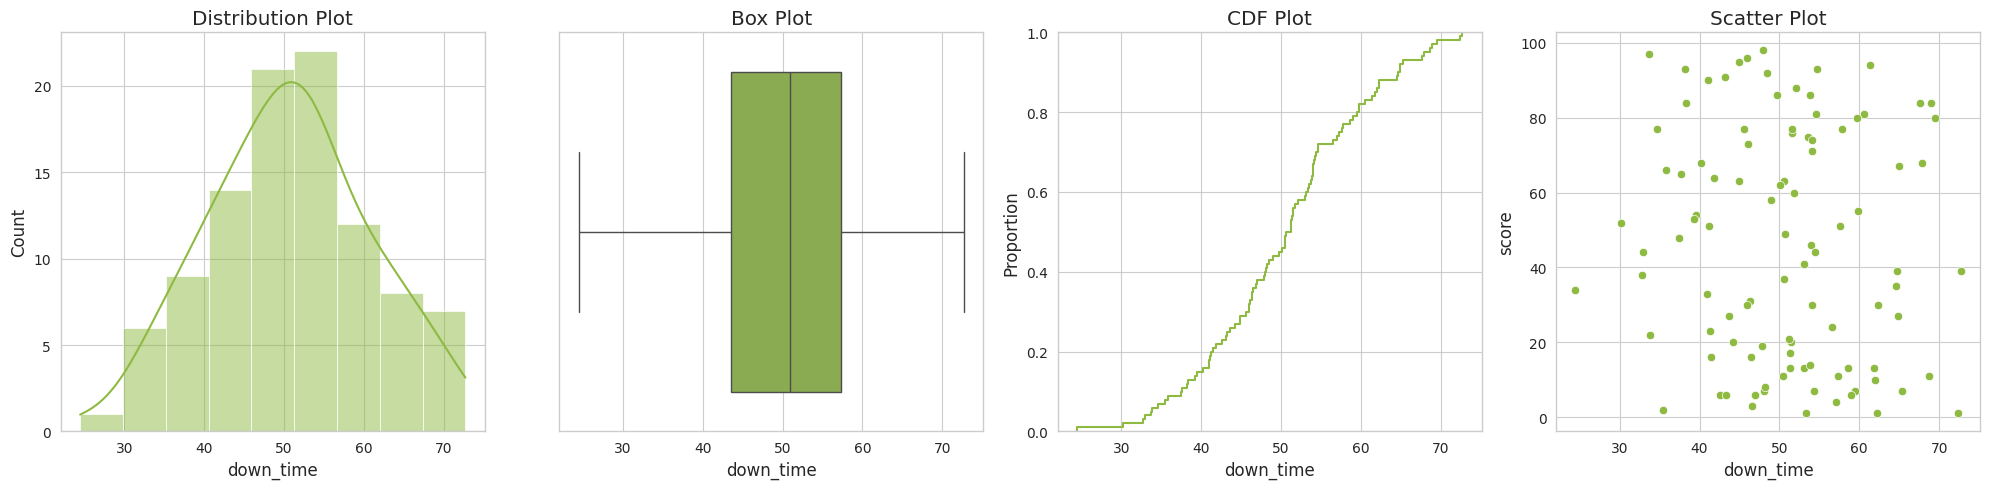

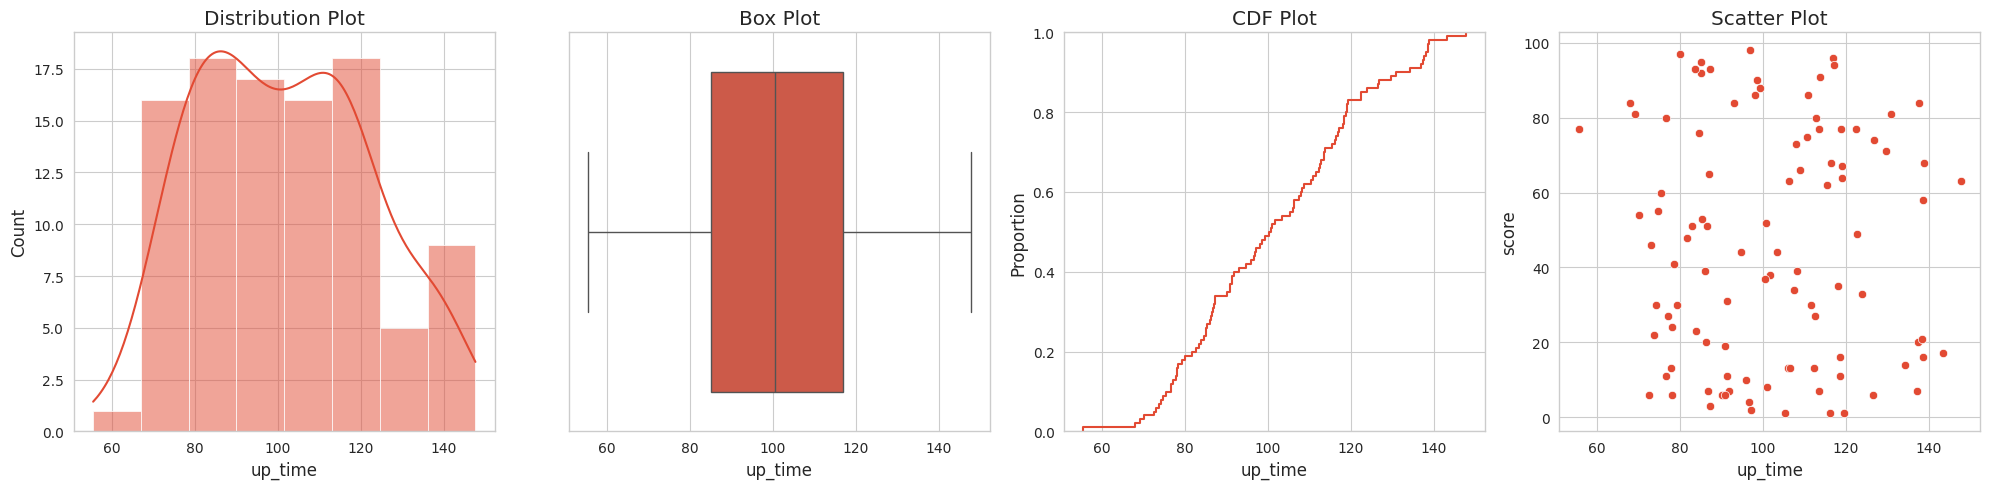

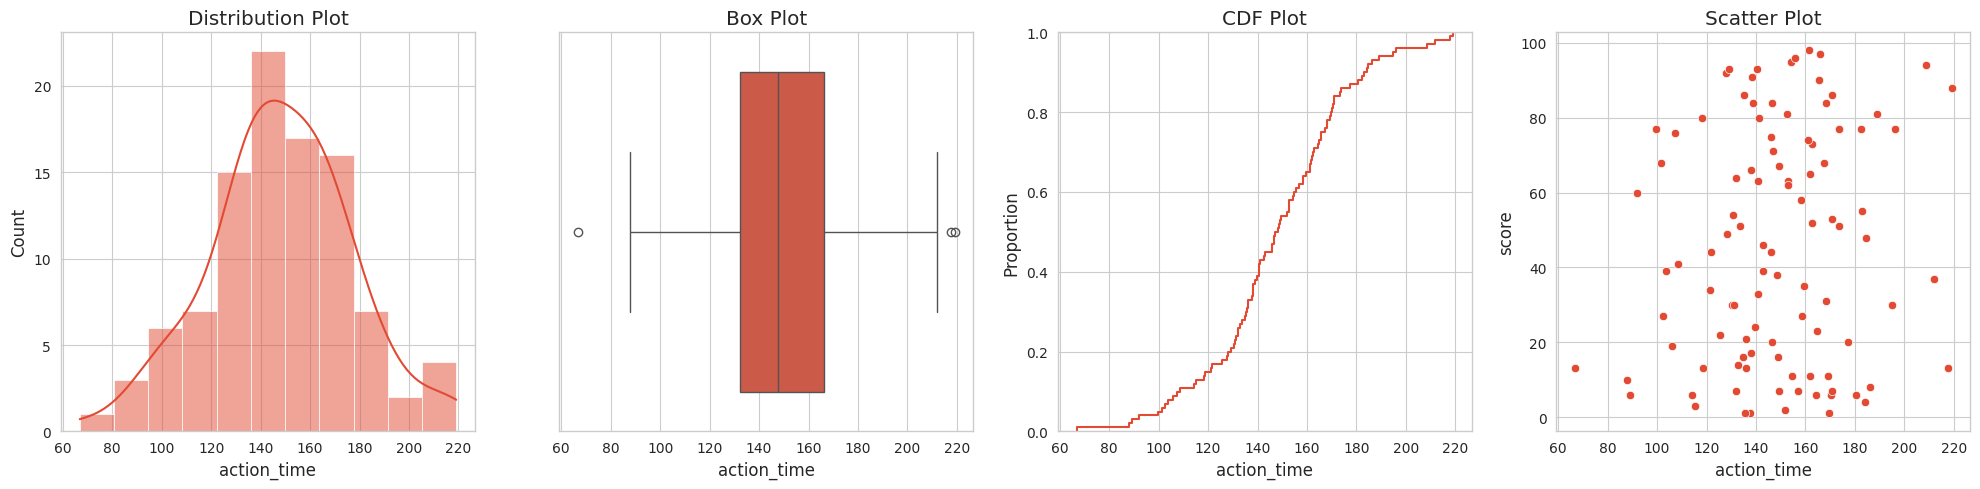

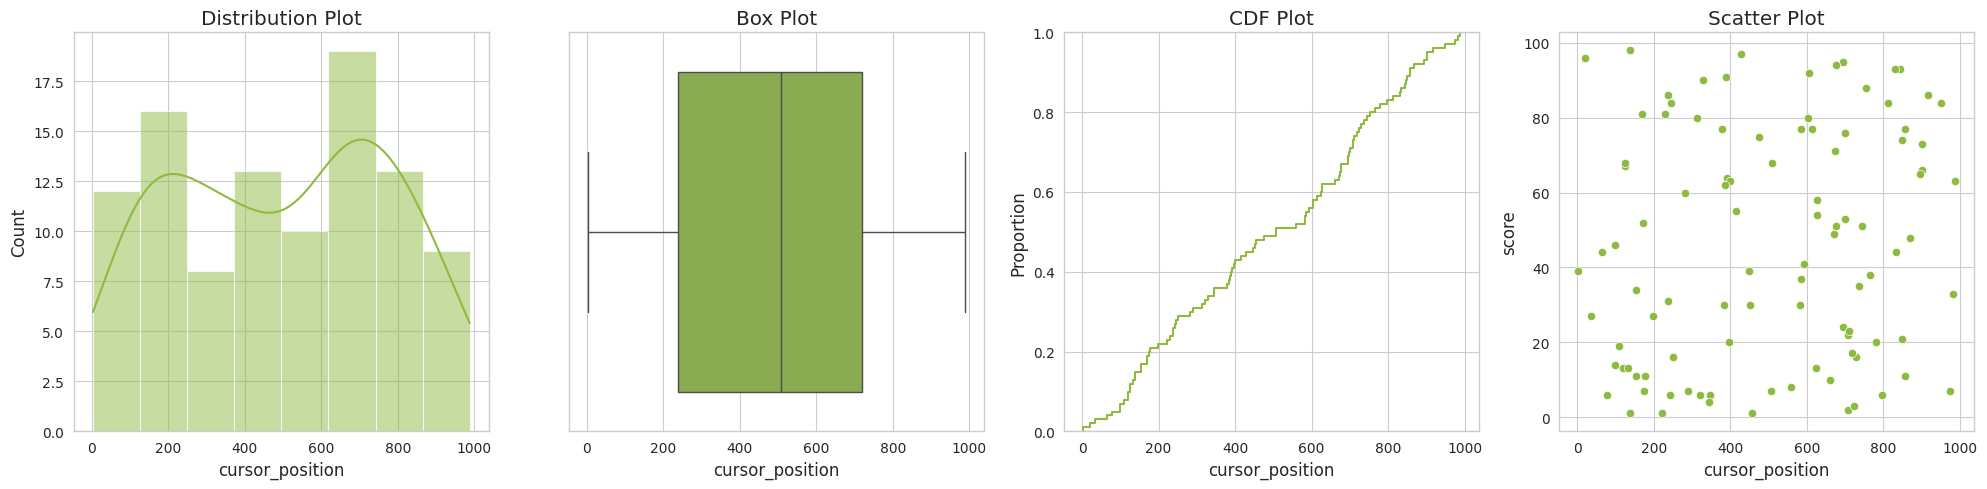

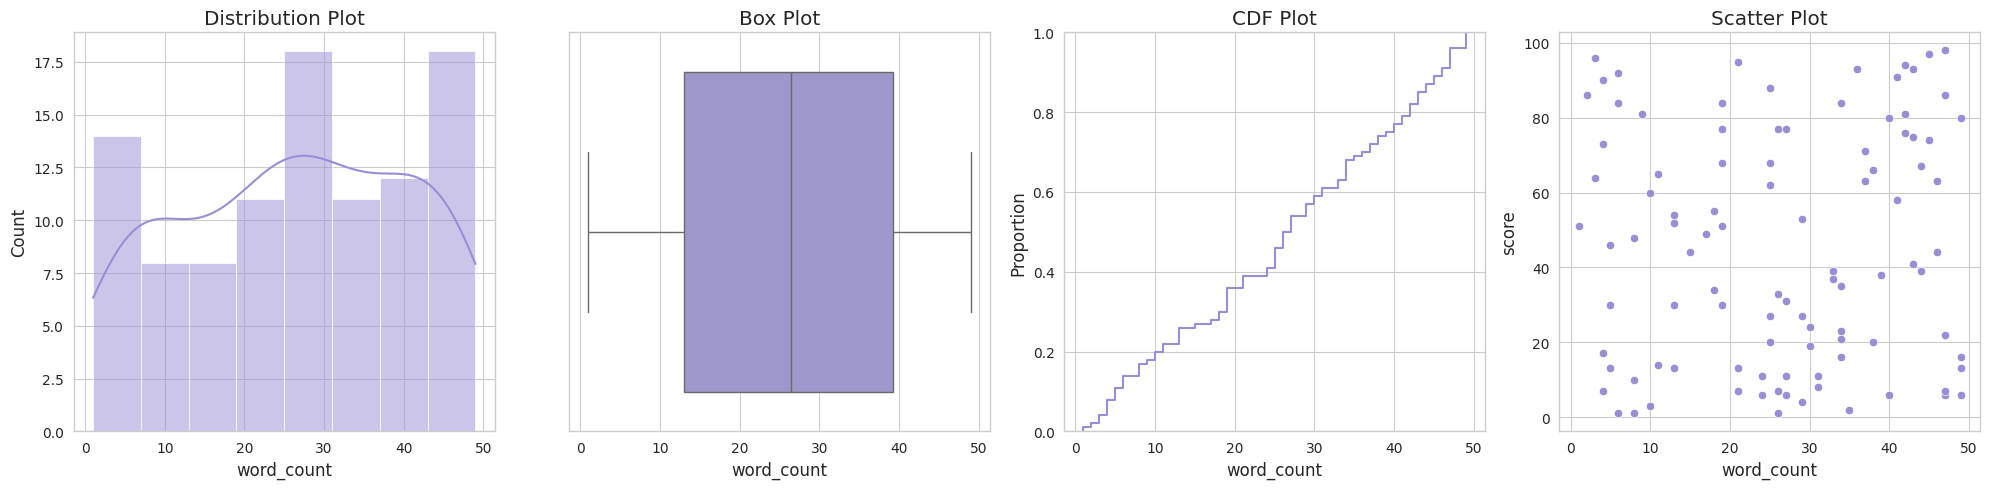

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice

# Create a synthetic dataset similar to train_logs_agg_df
np.random.seed(0) # For reproducibility
data_size = 100
train_logs_agg_df = pd.DataFrame({
    'down_time': np.random.normal(50, 10, data_size),
    'up_time': np.random.normal(100, 20, data_size),
    'action_time': np.random.normal(150, 30, data_size),
    'cursor_position': np.random.randint(0, 1000, data_size),
    'word_count': np.random.randint(1, 50, data_size),
    'score': np.random.randint(1, 100, data_size)
})

# Define the plot function
def plot_dist_box(data, target):
    color_pal = sns.color_palette() # Define a color palette
    color = choice(color_pal)

    # Create a figure with four subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Plot the distribution plot on the first subplot
    sns.histplot(data, ax=axes[0], color=color, kde=True)
    axes[0].set_title('Distribution Plot')

    # Plot the box plot on the second subplot
    sns.boxplot(x=data, ax=axes[1], color=color)
    axes[1].set_title('Box Plot')

    # Plot the CDF plot on the third subplot
    sns.ecdfplot(data, ax=axes[2], color=color)
    axes[2].set_title('CDF Plot')

    # Plot the scatter plot on the fourth subplot
    sns.scatterplot(x=data, y=target, ax=axes[3], color=color)
    axes[3].set_title('Scatter Plot')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

# Plotting for each numeric column against the score
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
for col in num_cols:
    plot_dist_box(train_logs_agg_df[col], train_logs_agg_df['score'])


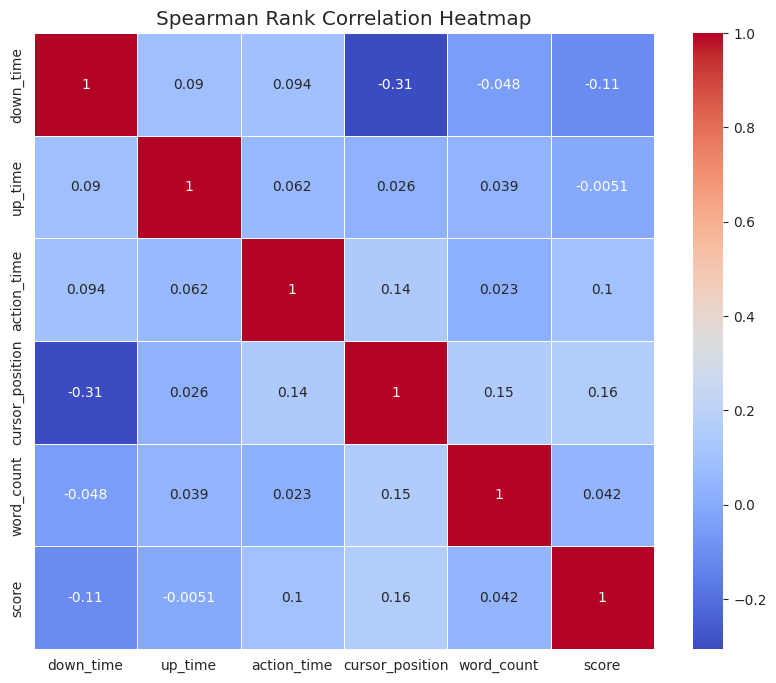

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Spearman's correlation
spearman_corr = train_logs_agg_df.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Spearman Rank Correlation Heatmap')
plt.show()


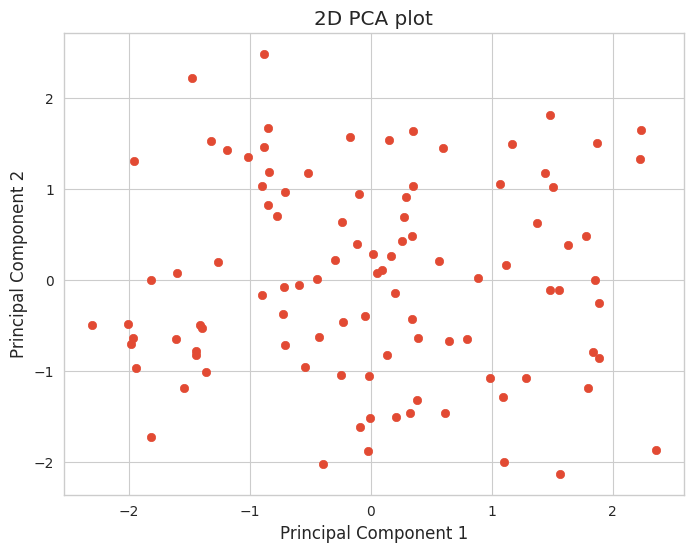

Explained Variance Ratio: [0.27354878 0.23347988]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select numerical features for PCA
features = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
x = train_logs_agg_df.loc[:, features].values

# Standardizing the features (important for PCA)
x = StandardScaler().fit_transform(x)

# PCA projection to 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Create a DataFrame with the PCA results
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# Plot the PCA result
plt.figure(figsize=(8,6))
plt.scatter(principalDf['PC1'], principalDf['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA plot')
plt.grid(True)
plt.show()

# Explained variance ratio
print('Explained Variance Ratio:', pca.explained_variance_ratio_)


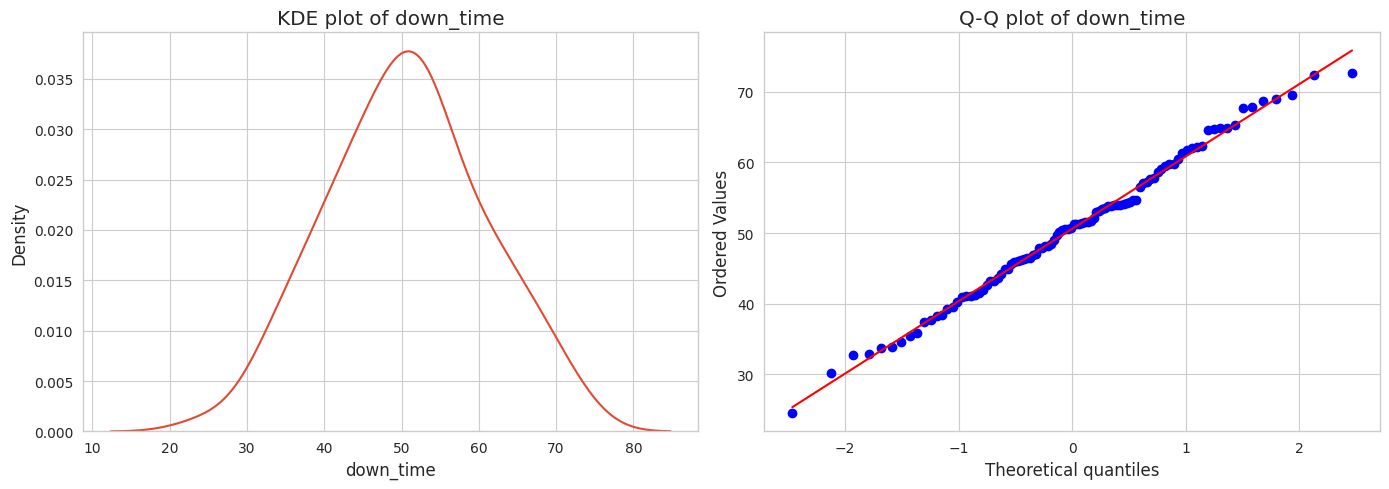

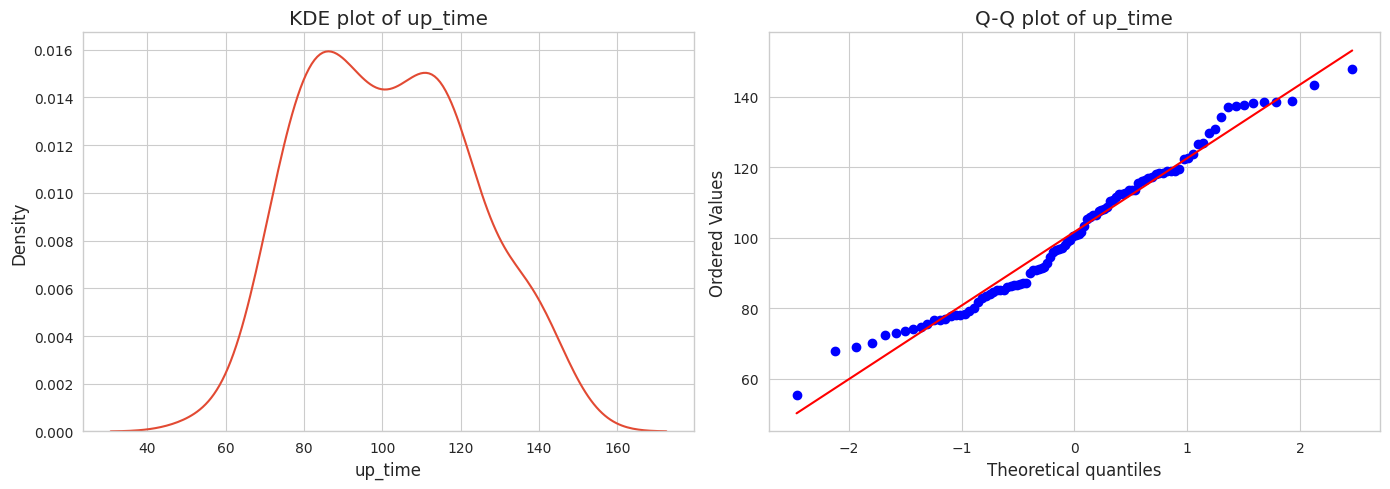

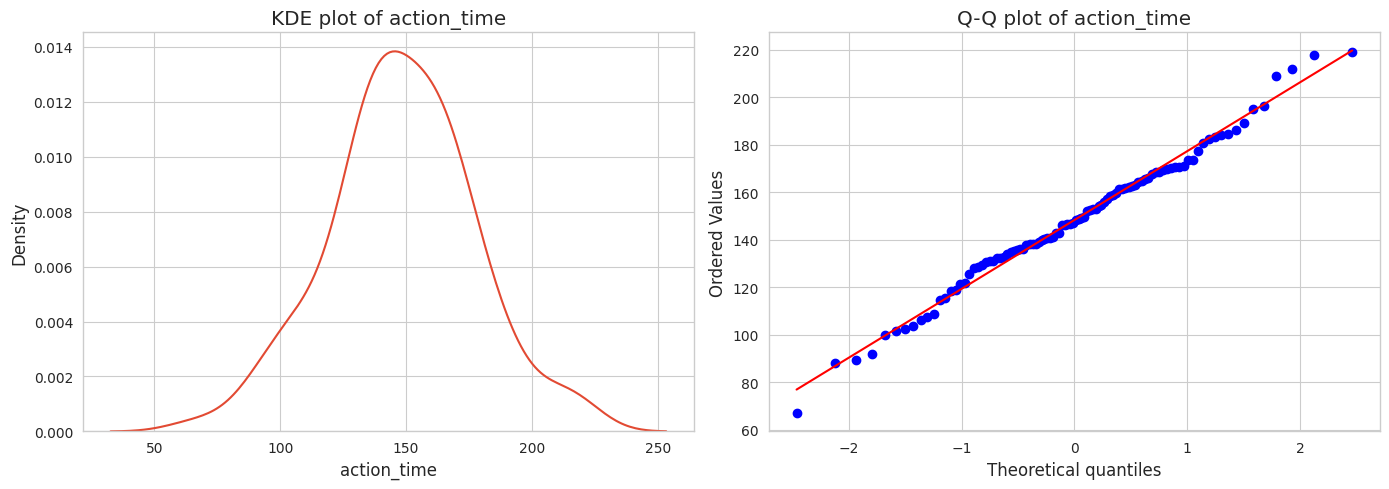

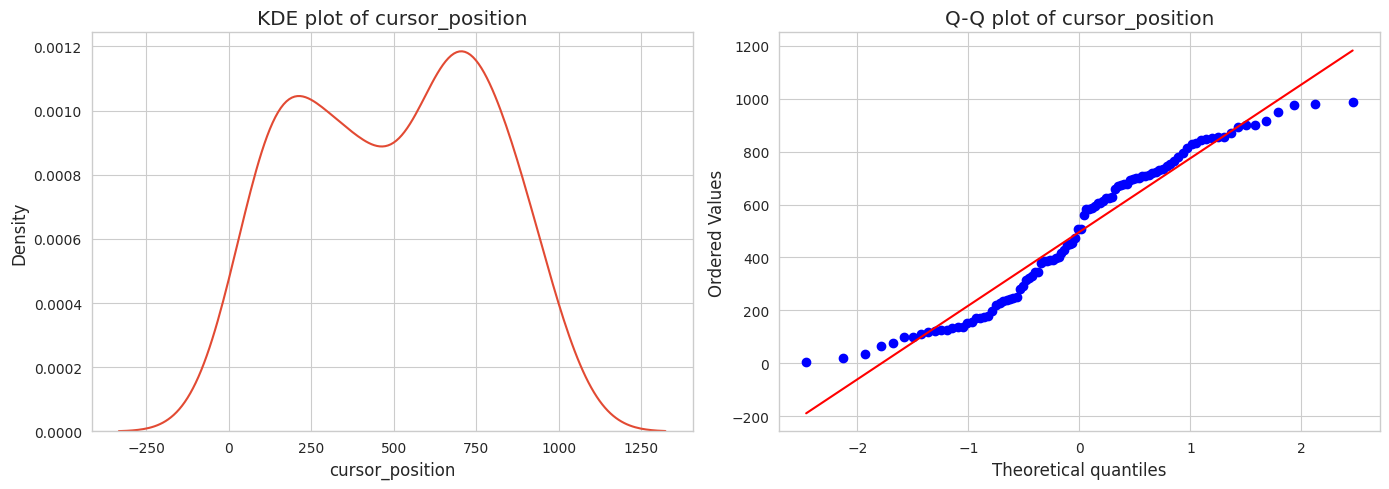

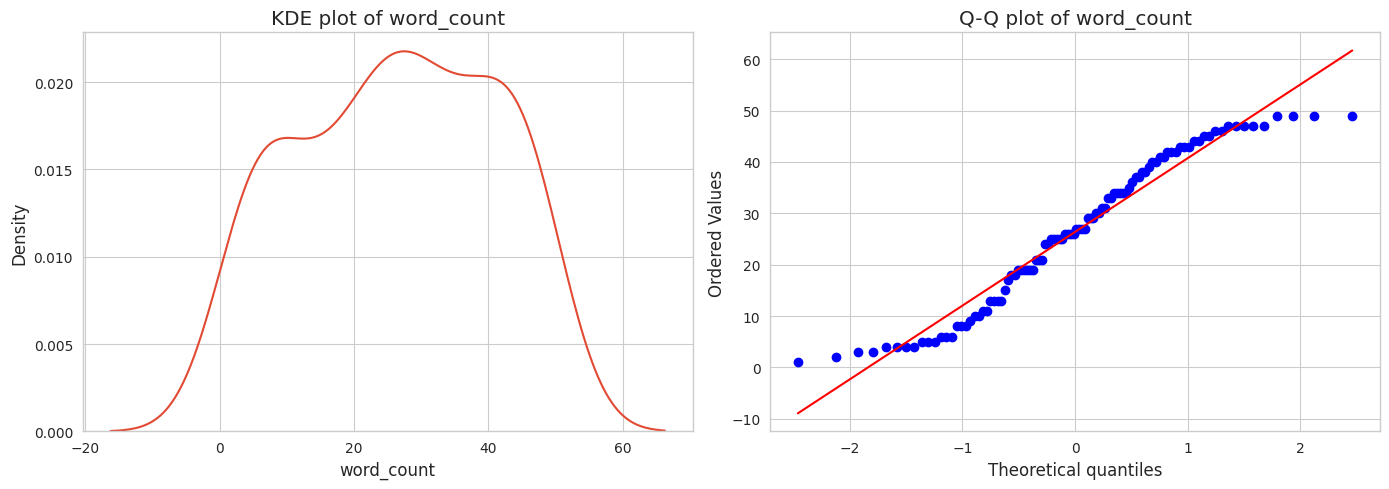

In [ ]:
# Redefine the required data as it wasn't defined in the code execution environment's current scope

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Create a synthetic dataset similar to train_logs_agg_df
np.random.seed(0)  # For reproducibility
data_size = 100
train_logs_agg_df = pd.DataFrame({
    'down_time': np.random.normal(50, 10, data_size),
    'up_time': np.random.normal(100, 20, data_size),
    'action_time': np.random.normal(150, 30, data_size),
    'cursor_position': np.random.randint(0, 1000, data_size),
    'word_count': np.random.randint(1, 50, data_size),
    'score': np.random.randint(1, 100, data_size)
})

# Numeric columns to perform advanced distribution analysis on
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']

# Function to create Q-Q plots and KDE plots
def advanced_distribution_analysis(data, feature_name):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # KDE plot
    sns.kdeplot(data, ax=ax[0])
    ax[0].set_title(f'KDE plot of {feature_name}')

    # Q-Q plot
    stats.probplot(data, dist="norm", plot=ax[1])
    ax[1].set_title(f'Q-Q plot of {feature_name}')

    plt.tight_layout()
    plt.show()

# Applying the advanced distribution analysis to each numeric column
for col in num_cols:
    advanced_distribution_analysis(train_logs_agg_df[col], col)


Down Time
KDE Plot:

The KDE plot for down_time shows a unimodal distribution that is quite symmetrical and bell-shaped, suggesting a distribution that approximates a normal distribution.
Q-Q Plot:

The Q-Q plot for down_time mostly aligns with the 45-degree line, especially in the central quantiles, but with slight deviations at both tails. This indicates that the distribution is close to normal but might have slight heavy tails, suggesting the presence of outliers or extreme values.
Up Time
KDE Plot:

The KDE plot for up_time indicates a slight skewness, as it is not perfectly symmetrical. There appears to be a slight tail on the right side of the plot, suggesting a distribution that has a longer tail on the higher value side.
Q-Q Plot:

The Q-Q plot for up_time again shows a distribution that follows the theoretical quantiles fairly closely for most of the data, with some deviation at the higher end, indicating potential outliers or a light heavy-tailed nature.
Action Time
KDE Plot:

The KDE plot for action_time is very symmetrical and bell-shaped, much like a normal distribution.
Q-Q Plot:

The Q-Q plot for action_time reveals that the data points align very well with the theoretical line, suggesting that the variable is normally distributed with very little deviation.
Cursor Position
KDE Plot:

The KDE for cursor_position shows a bimodal distribution, indicating the presence of two distinct groups within the dataset.
Q-Q Plot:

The Q-Q plot for cursor_position largely follows the theoretical line in the middle quantiles but shows deviation at the ends, especially on the upper side, suggesting that the data may have more extreme values than a normal distribution.
Word Count
KDE Plot:

The KDE plot for word_count also shows a unimodal distribution with a skew to the right, indicating a longer tail towards higher word counts.
Q-Q Plot:

Similar to up_time, the Q-Q plot for word_count mostly aligns with the theoretical line but with deviations at the lower and upper quantiles, indicating some outliers or a skew in the distribution.
General Insights:
Normality: action_time and down_time are the closest to normal distributions, suggesting that many statistical methods that assume normality could be directly applied.
Skewness: up_time and word_count show right skewness, which could affect certain statistical analyses. These variables might benefit from transformations such as logarithmic scaling to achieve normality.
Bimodality: cursor_position presents a bimodal distribution, which could indicate different subgroups or behaviors within the data. This warrants further investigation into what these modes represent.
Outliers: The Q-Q plots indicate the potential presence of outliers in each variable, particularly in up_time, cursor_position, and word_count. These outliers might need to be considered during data preprocessing and model training.
In summary, while some variables exhibit near-normal distributions, others show skewness or bimodality. Depending on the modeling techniques you plan to apply, you may need to consider transforming these variables or accounting for these distribution properties in your models.

In [ ]:
import seaborn as sns
from random import choice

def plot_dist_box(data, target):
    # Define a color palette inside the function
    color_pal = sns.color_palette()

    color = choice(color_pal)

    # Create a figure with four subplots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the distribution plot on the first subplot
    sns.histplot(data, ax=axes[0], color=color)
    axes[0].set_title('Distribution Plot')

    # Plot the box plot on the second subplot
    sns.boxplot(data, ax=axes[1], color=color)
    axes[1].set_title('Box Plot')

    # Plot the CDF plot on the third subplot
    sns.ecdfplot(data, ax=axes[2], color=color)
    axes[2].set_title('CDF Plot')

    # Plot the scatter plot on the fourth subplot
    sns.scatterplot(x=data, y=target, ax=axes[3], color=color)
    axes[3].set_title('Scatter Plot')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


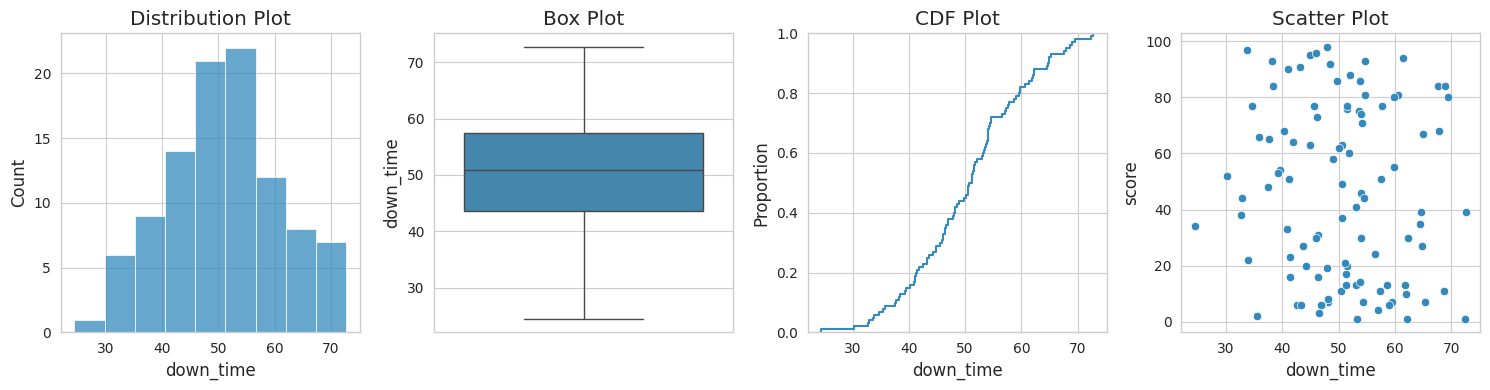

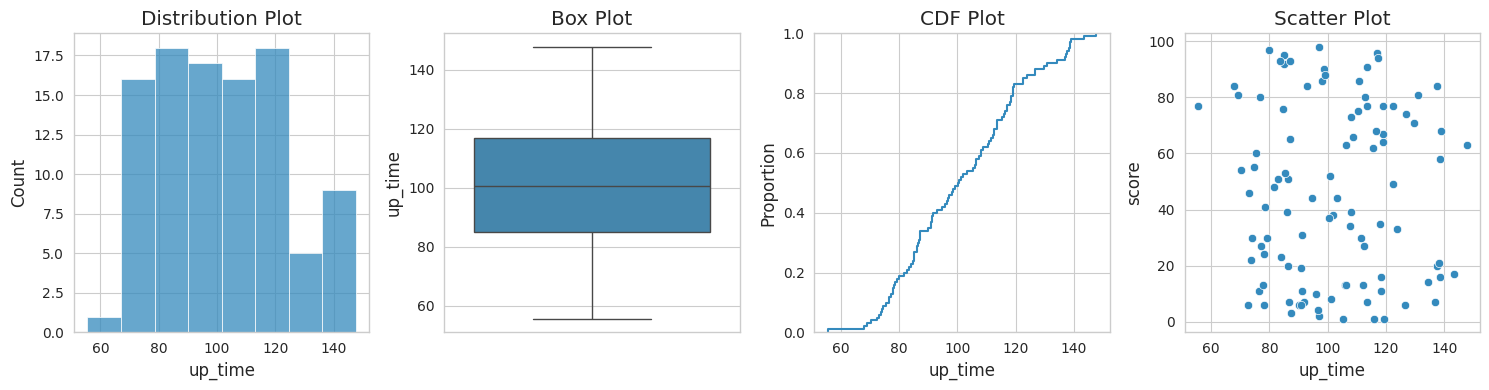

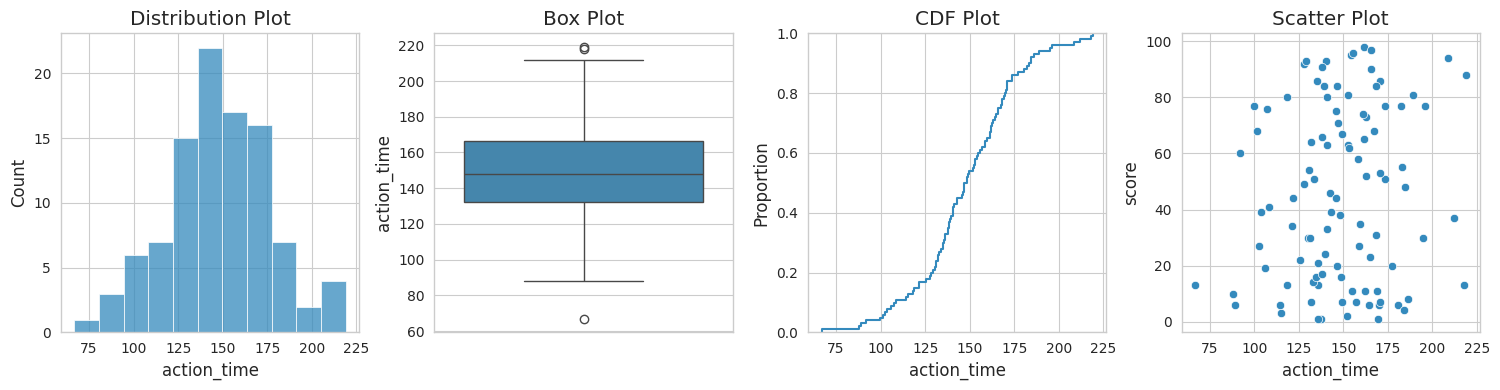

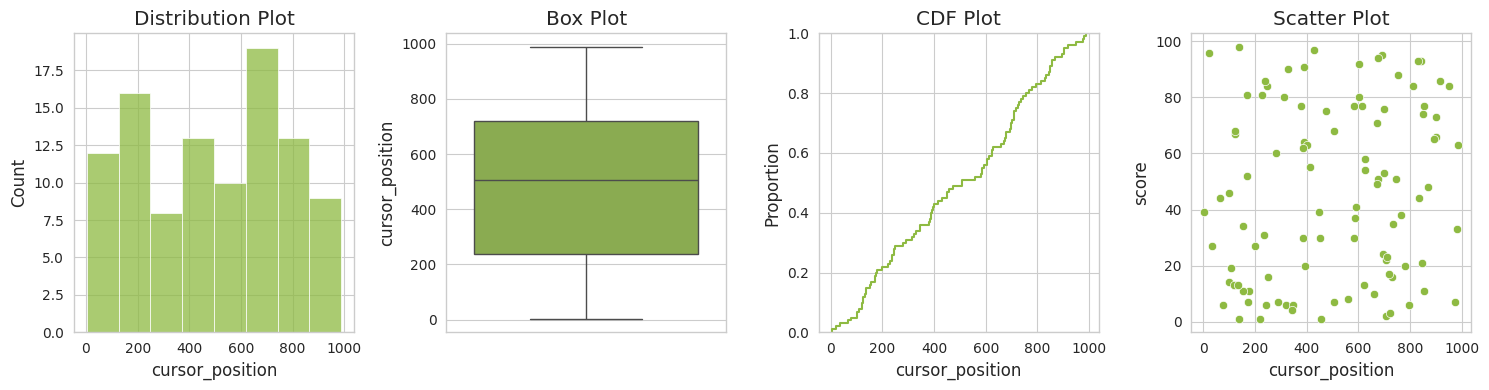

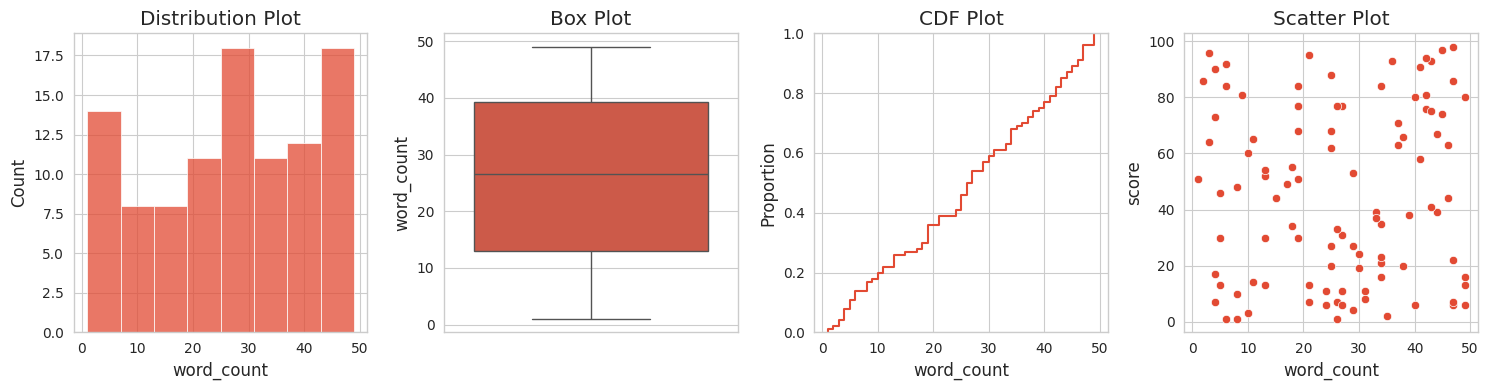

In [ ]:
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
for col in num_cols:
    plot_dist_box(train_logs_agg_df[col], train_logs_agg_df['score'])

In [ ]:
def plot_dist_box(data, target):

    color = choice(color_pal)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the distribution plot on the first subplot
    sns.histplot(data, ax=axes[0], color=color)
    axes[0].set_title('Distribution Plot')

    # Plot the box plot on the second subplot
    sns.boxplot(data, ax=axes[1], color=color)
    axes[1].set_title('Box Plot')

    # Plot the box plot on the second subplot
    sns.ecdfplot(data, ax=axes[2], color=color)
    axes[2].set_title('CDF Plot')

    # Plot the box plot on the second subplot
    sns.scatterplot(x=data, y=target, ax=axes[3], color=color)
    axes[3].set_title('Scatter Plot')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
train_logs['activity'].value_counts()

activity
Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [13, 65] To [9, 61]                   1
Move From [274, 314] To [299, 339]              1
Move From [624, 625] To [845, 846]              1
Move From [1861, 2063] To [1766, 1968]          1
Move From [1766, 1968] To [1861, 2063]          1
Move From [2091, 2179] To [252, 340]            1
Move From [923, 1077] To [340, 494]             1
Move From [0, 1] To [590, 591]                  1
Move From [999, 1000] To [1000, 1001]           1
Move From [0, 75] To [1, 76]                    1
Move From [1651, 1769] To [1565, 1683]          1
Move From [61, 136] To [0, 75]                  1
Move From [623, 632] To [624, 633]              1
Move From [75, 134] To [304, 363]        

In [ ]:
train_logs['down_event'].value_counts()

down_event
q             5365319
Space         1207128
Backspace      964089
Shift          334227
ArrowRight     121338
               ...   
F10                 1
Cancel              1
S                   1
T                   1
F6                  1
Name: count, Length: 131, dtype: int64

In [ ]:
train_logs['up_event'].value_counts()

up_event
q             5364789
Space         1207128
Backspace      964089
Shift          334227
ArrowRight     121338
               ...   
Cancel              1
T                   1
S                   1
M                   1
F6                  1
Name: count, Length: 130, dtype: int64

In [ ]:
train_logs['text_change'].value_counts()

text_change
q                                                                                                                                                               6128208
                                                                                                                                                                1376829
NoChange                                                                                                                                                         703851
.                                                                                                                                                                 67797
,                                                                                                                                                                 54797
                                                                                                                                                    

In [ ]:
class Preprocessor:

    def __init__(self, seed): #Initialise the preprocessor with a random seed for reproducibility
        self.seed = seed
#Define lists of different categories for activities, events, text changes, and punctuations
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',',
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]  #Time shifts for creating lag features    Sets up a list of gaps for creating lag features, useful in time series analysis or when order and timing of events are important
#         self.gaps = [1, 2]

    def activity_counts(self, df): #Count occurrences of each activity type in the dataframe
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['activity'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0                                                               #
            for item in items:                                                          #
                k, v = item[0], item[1]                                                 #
                if k in di:                                                             #
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

##Groups the input DataFrame by id and aggregates activities into lists. It then counts the occurrences of predefined activities for each id.
##Returns a DataFrame with columns for each activity count, indicating how often each activity occurred.

    def event_counts(self, df, colname): #Count occurrences of each event type in the specified column of the dataframe
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

##similar to above but counts occurrences of predefined events in the specified column for each group.
##Useful for understanding the distribution of different types of events (e.g., keystrokes, mouse clicks) across the dataset.

    def text_change_counts(self, df): #Count occurrences of each text change type in the dataframe
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols
        return ret
##Aggregates and counts occurrences of predefined text changes for each group.
##Text changes can include any modification to text, such as additions or deletions, which might point out user behavior or content evolution.

    def match_punctuations(self, df):          #Count total occurrences of punctuations in the 'down_event' column
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret


##Counts occurrences of predefined punctuation marks in the down_event column for each group, returning a count of punctuation events.
##Punctuation usage can provide insights into writing styles or indicate certain types of text input.

    def get_input_words(self, df):      #Extract and count input words from text changes, excluding specific patterns and 'NoChange'
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df

##Extracts and counts input words from text changes, excluding specific patterns and 'NoChange' entries. It calculates statistics on the length of these input words.
##This method can help analyze the complexity and variability of text input across different ids.

    def make_feats(self, df):
        #Print a message to indicate the start of feature engineering.
        print("Starting to engineer features")

        #Initialize a DataFrame to hold the features. This DataFrame starts with a unique identifier 'id' for each row.
        feats = pd.DataFrame({'id': df['id'].unique().tolist()})

        #get shifted features
        #time shift
        #Generate features based on time shifts for various 'gap' sizes defined in self.gaps.
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        #Generate features based on shifts in word count for each 'gap' size.
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        #Generate features based on shifts in word count for each 'gap' size.
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)

        #Aggregate statistical features for various columns in the dataset.
        print("Engineering statistical summaries for features")
        #Define a list of tuples specifying the column and the statistical methods to apply.
        #[(feature name, [ stat summaries to add ])]
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            ('action_time', ['sum', 'max', 'mean', 'std']),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'mean']),
            ('word_count', ['nunique', 'max', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'sum', skew, kurtosis]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'sum', skew, kurtosis]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'sum', skew, kurtosis])
            ])
        #Use a progress bar to iterate over each statistical feature to be calculated.
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:

                pbar.set_postfix()
                if isinstance(method, str):      #Update progress bar with current column and method for clarity.
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                #Aggregate the specified method for the column and merge it into the features DataFrame.
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')


##The core method where feature engineering occurs. It performs the following steps:
##Initializes a DataFrame to hold the features.
##Generates features based on time shifts, cursor position shifts, and word count changes.
##Aggregates various statistics (e.g., max, mean, standard deviation) for multiple columns.
###Merges generated features into the initial features DataFrame.
##Calculates ratios to create new features, providing insights into the efficiency, productivity, or typing dynamics.

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # input words
        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        # compare feats
        #Calculate and add ratio features to capture relationships between different types of data, such as word count to time.
        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']
        #Ratios are calculated to capture efficiency, productivity, or typing dynamics.

        print("Done!")  #Indicate the end of feature engineering.
        return feats    #Return the final DataFrame containing all engineered features.

The class encapsulates a detailed and structured approach to preprocessing complex event log data, transforming it into a format ready for analysis or modeling. This preprocessing includes counting event occurrences, creating lag features, aggregating statistical summaries, and generating ratio-based features, all of which are crucial for extracting meaningful insights from raw data.

In [ ]:
# Assumptions for calculations
num_activities = 5
num_events = 17 * 2  # down_event and up_event
num_text_changes = 14  # Assuming unique text change types listed
num_punctuations = 1  # Total count feature
num_ratios = 4
num_gaps = 8
stat_summaries_per_feature = 5  # Assuming an average for max, sum, mean, std, etc.

# Calculating dynamic features for gap sizes
# Each gap introduces multiple new features for action_time_gap, cursor_position_change, word_count_change
# Assuming 5 statistical summaries for each type of gap-based feature, and 3 types of gap-based features
dynamic_features_per_gap = 3 * stat_summaries_per_feature

# Total dynamic features from gaps
total_dynamic_features = num_gaps * dynamic_features_per_gap

# Total features
total_features = (num_activities + num_events + num_text_changes + num_punctuations + num_ratios + total_dynamic_features)

total_features


178

In [ ]:
#Initialize an instance of the Preprocessor class with a seed value.
#The seed ensures that any random operations within the preprocessor are reproducible.

preprocessor = Preprocessor(seed=42)


#Start the feature engineering process for the training dataset.
print("Engineering features for training data")


#Apply the make_feats method from the preprocessor instance on the training dataset.
#This method will perform all the feature engineering steps defined in the Preprocessor class,
#including shifting features, aggregating statistics, counting events, etc., and return
#a DataFrame with new features based on the training logs.
train_feats = preprocessor.make_feats(train_logs)

#Print a separator to visually distinguish the output between training and testing datasets.
print()
print("-"*25)
print("Engineering features for test data")
print("-"*25)

#Similarly, apply the make_feats method on the test dataset to engineer features.
#The process is the same as for the training data, ensuring consistency in the features
#engineered for both datasets. This step is crucial for the model to perform well on unseen data.
test_feats = preprocessor.make_feats(test_logs)

Engineering features for training data
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|██████████| 33/33 [03:03<00:00,  5.56s/it, column=word_count_change100, method=kurtosis]


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 4894.07it/s]


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 5062.68it/s]


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 4862.11it/s]


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 4912.15it/s]


Engineering input words data
Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|██████████| 33/33 [00:01<00:00, 16.53it/s, column=word_count_change100, method=kurtosis]


Engineering activity counts data


100%|██████████| 3/3 [00:00<00:00, 12972.07it/s]


Engineering event counts data


100%|██████████| 3/3 [00:00<00:00, 14855.86it/s]


Engineering text change counts data


100%|██████████| 3/3 [00:00<00:00, 13873.11it/s]


Engineering punctuation counts data


100%|██████████| 3/3 [00:00<00:00, 17573.90it/s]


Engineering input words data
Engineering ratios data
Done!


In [ ]:
train_feats.shape

(2471, 230)

In [ ]:
train_feats

id  event_id_max  up_time_max  action_time_sum  action_time_max  \
0     001519c8          2557      1801969           297243             2259   
1     0022f953          2454      1788969           275391             1758   
2     0042269b          4136      1771669           421201             3005   
3     0059420b          1556      1404469           189596              806   
4     0075873a          2531      1662472           313702              701   
...        ...           ...          ...              ...              ...   
2466  ffb8c745          4739      1791649           499670             3323   
2467  ffbef7e5          2604      1799174           214221             1144   
2468  ffccd6fd          3063      1959363           231580              564   
2469  ffec5b38          3242      1508504           289439             1388   
2470  fff05981          3619      2070133           301235             1915   

      action_time_mean  action_time_std  activity_nunique  down_event_nunique  \
0           116.246774        91.797374                 7                  12   
1           112.221271        55.431189                 5                  17   
2           101.837766        82.383766                 4                  13   
3           121.848329       113.768226                 5                  15   
4           123.943896        62.082013                 3                  11   
...                ...              ...               ...                 ...   
2466        105.437856        63.622575                 4                  13   
2467         82.266129        36.178818                 4                  11   
2468         75.605615        63.494975                 3                  11   
2469         89.277915        54.515788                 3                  15   
2470         83.237082        63.738723                 6                  23   

      up_event_nunique  text_change_nunique  cursor_position_nunique  \
0                   12                   17                     1469   
1                   17                   12                     1416   
2                   18                   19                     1649   
3                   15                   10                     1048   
4                   11                    9                     1197   
...                ...                  ...                      ...   
2466                13                   13                     1484   
2467                11                    8                     1808   
2468                11                    6                     2759   
2469                15                   13                     2106   
2470                24                   46                     1392   

      cursor_position_max  cursor_position_mean  word_count_nunique  \
0                    1539            711.163473                 257   
1                    1676            776.205786                 324   
2                    2291            731.611702                 405   
3                    1047            542.537275                 207   
4                    1402            600.050968                 253   
...                   ...                   ...                 ...   
2466                 1634            774.000633                 462   
2467                 1877           1022.078725                 439   
2468                 2761           1309.085537                 202   
2469                 2133           1192.640962                 414   
2470                 1496            589.173805                 242   

      word_count_max  word_count_mean  action_time_gap1_max  \
0                256       128.116152              154136.0   
1                323       182.714751              145899.0   
2                404       194.772727              153886.0   
3                206       103.618895              101690.0   
4                252       125.082971              110688

In [ ]:
num_cols

['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']

In [ ]:
#Group the 'train_logs' DataFrame by the 'id' column. For each group, calculate specific statistical measures
#(mean, standard deviation, min, max, last, first, standard error of the mean, median, and sum)
#for the columns: 'down_time', 'up_time', 'action_time', 'cursor_position', 'word_count'.
#This aggregation helps summarize the data, providing insights into its central tendency, variability, and distribution.

train_agg_fe_df = train_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])

#After aggregation, the columns become MultiIndex (hierarchical index) in the format ('column_name', 'aggregation_function').
#The following line concatenates these levels into a single level, creating a flat list of column names in the format 'column_name_aggregation_function'.
#This makes the DataFrame easier to work with by providing clear, descriptive column names.

train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]

#Add a prefix 'tmp_' to each column name. This is typically done to temporarily distinguish or highlight these features,
#or to prevent column name conflicts with other DataFrames in a larger data processing pipeline.

train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")

#Reset the index of the DataFrame. Since the groupby operation makes 'id' the index of the resulting DataFrame,
#resetting the index will move 'id' back to a column, making the DataFrame easier to merge or join with other DataFrames.
#The resulting DataFrame is now ready for further analysis or feature engineering steps.

train_agg_fe_df.reset_index(inplace=True)

In [ ]:
# Group the 'test_logs' DataFrame by the 'id' column and calculate statistical metrics for selected columns.
# The metrics calculated are mean, standard deviation, minimum, maximum, last value, first value,
# standard error of the mean, median, and sum. These operations are applied to the columns
# 'down_time', 'up_time', 'action_time', 'cursor_position', and 'word_count'.
# This aggregation is useful for summarizing the behavior of these features within each unique 'id',
# providing a comprehensive overview of the data's statistical properties.
test_agg_fe_df = test_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
#The resulting DataFrame from the aggregation has a MultiIndex for its columns, where the first level is the
#name of the original column and the second level is the name of the aggregation function applied.
#The next line of code combines these levels into a single string for each column, formatted as 'columnname_aggregationfunction'.
#This simplifies the DataFrame structure, making it easier to reference and use the aggregated columns.

test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]

#Adds a prefix "tmp_" to all column names in the DataFrame. This prefixing can help to identify or segregate
#these columns within a larger dataset, especially when merging this DataFrame with others that might have overlapping column names.
#It's a useful technique for namespace management within a data processing workflow.

test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")

#Resets the index of the DataFrame. The grouping operation previously set 'id' as the index,
#so resetting the index moves 'id' back into the DataFrame as a regular column and introduces a new numerical index.
#This step is often necessary when preparing the aggregated data for further analysis, merging, or modeling,
#as it standardizes the DataFrame format.

test_agg_fe_df.reset_index(inplace=True)

In [ ]:
train_agg_fe_df.head()

id  tmp_down_time_mean  tmp_down_time_std  tmp_down_time_min  \
0  001519c8       848180.771998      395112.665961               4526   
1  0022f953       518855.347596      384959.404177              30623   
2  0042269b       828491.775145      489500.796565               4441   
3  0059420b       785483.026350      385205.014399              41395   
4  0075873a       713354.197550      405576.409034              78470   

   tmp_down_time_max  tmp_down_time_last  tmp_down_time_first  \
0            1801877             1801877                 4526   
1            1788842             1788842                30623   
2            1771219             1771219                 4441   
3            1404394             1404394                41395   
4            1662390             1662390                78470   

   tmp_down_time_sem  tmp_down_time_median  tmp_down_time_sum  \
0        7813.679400              891716.0         2168798234   
1        7771.013336              407673.0         1273271023   
2        7611.375322              759582.0         3426641982   
3        9765.334758              848240.5         1222211589   
4        8061.699636              686588.0         1805499474   

   tmp_up_time_mean  tmp_up_time_std  tmp_up_time_min  tmp_up_time_max  \
0     848297.018772    395105.685655             4557          1801969   
1     518967.568867    384952.728796            30853          1788969   
2     828593.612911    489500.438784             4540          1771669   
3     785604.874679    385206.081250            41513          1404469   
4     713478.141446    405575.631746            78693          1662472   

   tmp_up_time_last  tmp_up_time_first  tmp_up_time_sem  tmp_up_time_median  \
0           1801969               4557      7813.541359            891802.0   
1           1788969              30853      7770.878583            407789.0   
2           1771669               4540      7611.369759            759674.5   
3           1404469              41513      9765.361803            848405.5   
4           1662472              78693      8061.684185            686728.0   

   tmp_up_time_sum  tmp_action_time_mean  tmp_action_time_std  \
0       2169095477            116.246774            91.797374   
1       1273546414            112.221271            55.431189   
2       3427063183            101.837766            82.383766   
3       1222401185            121.848329           113.768226   
4       1805813176            123.943896            62.082013   

   tmp_action_time_min  tmp_action_time_max  tmp_action_time_last  \
0                    0                 2259                    92   
1                    0                 1758                   127   
2                    0                 3005                   450   
3                    0                  806                    75   
4                    0                  701                    82   

   tmp_action_time_first  tmp_action_time_sem  tmp_action_time_median  \
0                     31             1.815369                   112.0   
1                    230             1.118966                   115.0   
2                     99             1.281007                    94.0   
3                    118             2.884139                   110.0   
4                    223             1.234013                   129.0   

   tmp_action_time_sum  tmp_cursor_position_mean  tmp_cursor_position_std  \
0               297243                711.163473               439.359619   
1               275391                776.205786               449.133174   
2               421201                731.611702               592.769763   
3               189596                542.537275               307.627200   
4               313702                600.050968               341.729409   

   tmp_cursor_position_min  tmp_cursor_position_max  tmp_cursor_position_last  \
0                        0                     1539                      1046  

In [ ]:
test_agg_fe_df.head()

id  tmp_down_time_mean  tmp_down_time_std  tmp_down_time_min  \
0  0000aaaa            549253.0      298144.503219             338433   
1  2222bbbb            501229.0      298012.981358             290502   
2  4444cccc            410271.5      318587.667370             184996   

   tmp_down_time_max  tmp_down_time_last  tmp_down_time_first  \
0             760073              760073               338433   
1             711956              290502               711956   
2             635547              184996               635547   

   tmp_down_time_sem  tmp_down_time_median  tmp_down_time_sum  \
0           210820.0              549253.0            1098506   
1           210727.0              501229.0            1002458   
2           225275.5              410271.5             820543   

   tmp_up_time_mean  tmp_up_time_std  tmp_up_time_min  tmp_up_time_max  \
0          549339.0    298145.917433           338518           760160   
1          501285.5    298027.830601           290548           712023   
2          410346.5    318614.537428           185052           635641   

   tmp_up_time_last  tmp_up_time_first  tmp_up_time_sem  tmp_up_time_median  \
0            760160             338518         210821.0            549339.0   
1            290548             712023         210737.5            501285.5   
2            185052             635641         225294.5            410346.5   

   tmp_up_time_sum  tmp_action_time_mean  tmp_action_time_std  \
0          1098678                  86.0             1.414214   
1          1002571                  56.5            14.849242   
2           820693                  75.0            26.870058   

   tmp_action_time_min  tmp_action_time_max  tmp_action_time_last  \
0                   85                   87                    87   
1                   46                   67                    46   
2                   56                   94                    56   

   tmp_action_time_first  tmp_action_time_sem  tmp_action_time_median  \
0                     85                  1.0                    86.0   
1                     67                 10.5                    56.5   
2                     94                 19.0                    75.0   

   tmp_action_time_sum  tmp_cursor_position_mean  tmp_cursor_position_std  \
0                  172                       0.5                 0.707107   
1                  113                       0.5                 0.707107   
2                  150                       0.5                 0.707107   

   tmp_cursor_position_min  tmp_cursor_position_max  tmp_cursor_position_last  \
0                        0                        1                         1   
1                        0                        1                         1   
2                        0                        1                         1   

   tmp_cursor_position_first  tmp_cursor_position_sem  \
0                          0                      0.5   
1                          0                      0.5   
2                          0                      0.5   

   tmp_cursor_position_median  tmp_cursor_position_sum  tmp_word_count_mean  \
0                         0.5                        1                  0.0   
1                         0.5                        1                  1.0   
2                         0.5                        1                  0.5   

   tmp_word_count_std  tmp_word_count_min  tmp_word_count_max  \
0            0.000000                   0                   0   
1            0.000000                   1                   1   
2            0.707107                   0                   1   

   tmp_word_count_last  tmp_word_count_first  tmp_word_count_sem  \
0                    0                     0                 0.0   
1                    1                     1                 0.0   
2                    1                     0                 0.5   

   tmp_word_count_median  tmp_word_

In [ ]:
#Merge the aggregated features from 'train_agg_fe_df' into the 'train_feats' DataFrame.
#The merge is performed on the 'id' column, ensuring that each record's aggregated features
#are correctly aligned with the corresponding 'id' in 'train_feats'.
#The 'how' parameter is set to 'left', meaning that all rows from 'train_feats' will be kept in the result,
#even if there is no matching 'id' in 'train_agg_fe_df'. In such cases, the aggregated feature columns will contain NaN values.
#This operation enriches the 'train_feats' DataFrame with statistical summaries of various measures
#(e.g., down_time, up_time), providing a more detailed feature set for model training.


train_feats = train_feats.merge(train_agg_fe_df, on='id', how='left')


#Similarly, merge the aggregated features from 'test_agg_fe_df' into the 'test_feats' DataFrame.
#This merge also uses the 'id' column for alignment and applies a 'left' join, ensuring that all rows in 'test_feats'
#are retained in the merged DataFrame. Aggregated features from 'test_agg_fe_df' are added to the 'test_feats' DataFrame,
#where available. As with the training data, this step adds valuable statistical information to the testing data,
#potentially improving the model's ability to make accurate predictions.
test_feats = test_feats.merge(test_agg_fe_df, on='id', how='left')

In [ ]:
train_feats.shape, test_feats.shape

((2471, 275), (3, 275))

In [ ]:
#Merge the 'train_scores' DataFrame into the 'train_feats' DataFrame on the 'id' column.
#This operation aligns and adds the scores or target values from 'train_scores' to their corresponding records in 'train_feats'.
#The merge is performed using a 'left' join, which means all rows from 'train_feats' will be included in the resulting DataFrame.
#If there is no matching 'id' in 'train_scores' for an 'id' in 'train_feats', the score columns will contain NaN values for that 'id'.
#This step is essential for supervised learning models, as it combines the features and target values into a single DataFrame,
#enabling the model to learn the relationship between the features and the target.

train_feats = train_feats.merge(train_scores, on='id', how='left')

In [ ]:
train_feats.head()

id  event_id_max  up_time_max  action_time_sum  action_time_max  \
0  001519c8          2557      1801969           297243             2259   
1  0022f953          2454      1788969           275391             1758   
2  0042269b          4136      1771669           421201             3005   
3  0059420b          1556      1404469           189596              806   
4  0075873a          2531      1662472           313702              701   

   action_time_mean  action_time_std  activity_nunique  down_event_nunique  \
0        116.246774        91.797374                 7                  12   
1        112.221271        55.431189                 5                  17   
2        101.837766        82.383766                 4                  13   
3        121.848329       113.768226                 5                  15   
4        123.943896        62.082013                 3                  11   

   up_event_nunique  text_change_nunique  cursor_position_nunique  \
0                12                   17                     1469   
1                17                   12                     1416   
2                18                   19                     1649   
3                15                   10                     1048   
4                11                    9                     1197   

   cursor_position_max  cursor_position_mean  word_count_nunique  \
0                 1539            711.163473                 257   
1                 1676            776.205786                 324   
2                 2291            731.611702                 405   
3                 1047            542.537275                 207   
4                 1402            600.050968                 253   

   word_count_max  word_count_mean  action_time_gap1_max  \
0             256       128.116152              154136.0   
1             323       182.714751              145899.0   
2             404       194.772727              153886.0   
3             206       103.618895              101690.0   
4             252       125.082971              110688.0   

   action_time_gap1_min  action_time_gap1_mean  action_time_gap1_std  \
0                -142.0             586.932707           4294.022274   
1                -166.0             604.547493           4897.303641   
2                -250.0             325.520435           3937.359025   
3                -516.0             754.648232           4242.152639   
4                -158.0             502.094862           3896.209237   

   action_time_gap1_sum  action_time_gap1_skew  action_time_gap1_kurtosis  \
0             1500200.0                    NaN                        NaN   
1             1482955.0                    NaN                        NaN   
2             1346027.0                    NaN                        NaN   
3             1173478.0                    NaN                        NaN   
4             1270300.0                    NaN                        NaN   

   cursor_position_change1_max  cursor_position_change1_mean  \
0                        591.0                      0.409233   
1                       1336.0                      0.619242   
2                       1826.0                      0.118742   
3                        100.0                      0.512540   
4                        468.0                      0.554150   

   cursor_position_change1_std  cursor_position_change1_sum  \
0                    43.378153                       1046.0   
1                    85.350330                       1519.0   
2                    72.082931                        491.0   
3                    10.014035                        797.0   
4                    24.406657                       1402.0   

   cursor_position_change1_skew  cursor_position_change1_kurtosis  \
0                           NaN                               NaN   
1                           NaN                               NaN   
2                           NaN

In [ ]:
#Define the name(s) of the target column(s) that the model will predict. In this case, the target is 'score'.
target_col = ['score']

#Define a list of column names to be excluded from the features, such as identifiers that are not predictive.
drop_cols = ['id']

#Construct the list of feature names to be used for training by excluding the target and drop columns from
#the list of all columns in 'train_feats'. This is done by filtering out any columns that are in 'target_col' or 'drop_cols'.
#The resulting 'train_cols' list contains the names of columns that will be used as features for model training.
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

#Calculate the lengths of the 'train_cols' and 'target_col' lists. The length of 'train_cols' indicates the number of features
#that will be used for training the model, while the length of 'target_col' shows the number of target variables.
#These lengths are important for understanding the dimensionality of the training data and the task's complexity
#(e.g., single-target vs. multi-target regression or classification).
train_cols.__len__(), target_col.__len__()


(274, 1)

In [ ]:
## implementing a K-Fold cross-validation strategy for training and evaluating a LightGBM regression model on a dataset, and then making predictions on a separate test dataset
#Initialize a KFold object from scikit-learn's model_selection module with 5 splits.
#The random_state ensures reproducibility, and shuffle=True randomizes the split of the data.

kf = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)


#Initialize an array of zeros with the same length as the number of rows in train_feats.
#This array will store the out-of-fold (OOF) predictions for the validation sets.

oof_valid_preds = np.zeros(train_feats.shape[0], )

#Prepare the test dataset features using the previously identified training columns (train_cols).
X_test = test_feats[train_cols]
test_predict_list = []   #Initialize a list to store predictions for each fold on the test dataset.

#Enumerate over each fold, using kf.split to generate indices for the training and validation sets.
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):

    print("==-"* 50)      #Print a divider for readability.
    print("Fold : ", fold)   #Print the current fold number.

    #Slice the train_feats DataFrame to create training and validation sets for features (X) and targets (y).
    X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
    X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

    #Print the shapes of the training and validation datasets for sanity check.
    print("Trian :", X_train.shape, y_train.shape)
    print("Valid :", X_valid.shape, y_valid.shape)

    #Define the parameters for the LightGBM regressor model.
    params = {
            "objective": "regression",   #Define the task as regression.
            "metric": "rmse",       #Use RMSE (Root Mean Square Error) as the evaluation metric.
            "n_estimators" : 10000,   #Maximum number of trees to build.
            "boosting_type": "gbdt",   #Use Gradient Boosting Decision Tree algorithm.
            "seed": 42 #Seed for reproducibility.
    }

    #Initialize the LightGBM regressor model with the specified parameters.
    model = lgb.LGBMRegressor(**params)

    #Define callbacks for early stopping (to prevent overfitting) and logging the evaluation.
    early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)

    #Fit the model to the training data, using the validation set for early stopping.
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
              callbacks=[early_stopping_callback, verbose_callback],
    )

    #Make predictions on the validation set and store them in the OOF predictions array.
    valid_predict = model.predict(X_valid)
    oof_valid_preds[valid_idx] = valid_predict

    #Make predictions on the test set and store them in the list of test predictions.
    test_predict = model.predict(X_test)
    test_predict_list.append(test_predict)

    #Calculate the RMSE score for the validation predictions and print it.
    score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
    print("Fold RMSE Score : ", score)

#Calculate the overall RMSE score for the OOF predictions and print it.
#This gives an estimate of the model's performance on unseen data.
oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
print("OOF RMSE Score : ", oof_score)

==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (1976, 274) (1976, 1)
Valid : (495, 274) (495, 1)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45394
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 220
[LightGBM] [Info] Start training from score 3.709008
[100]	valid_0's rmse: 0.605613
[200]	valid_0's rmse: 0.610845
Fold RMSE Score :  0.5968554420776225
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (1977, 274) (1977, 1)
Valid : (494, 274) (494, 1)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004113 seconds.
You can set `fo

In [ ]:
test_predict_list

[array([1.53538247, 1.51824298, 1.5280745 ]),
 array([1.33549274, 1.33347451, 1.33347451]),
 array([1.43623349, 1.42304983, 1.44471459]),
 array([1.50119073, 1.50980272, 1.50980272]),
 array([1.63426368, 1.69213134, 1.69213134])]

In [ ]:
np.mean(test_predict_list, axis=0)

array([1.48851262, 1.49534028, 1.50163953])

In [ ]:
test_feats.head()

id  event_id_max  up_time_max  action_time_sum  action_time_max  \
0  0000aaaa             2       760160              172               87   
1  2222bbbb             2       712023              113               67   
2  4444cccc             2       635641              150               94   

   action_time_mean  action_time_std  activity_nunique  down_event_nunique  \
0              86.0         1.414214                 1                   1   
1              56.5        14.849242                 1                   1   
2              75.0        26.870058                 1                   2   

   up_event_nunique  text_change_nunique  cursor_position_nunique  \
0                 1                    1                        2   
1                 1                    1                        2   
2                 2                    2                        2   

   cursor_position_max  cursor_position_mean  word_count_nunique  \
0                    1                   0.5                   1   
1                    1                   0.5                   1   
2                    1                   0.5                   2   

   word_count_max  word_count_mean  action_time_gap1_max  \
0               0              0.0              421555.0   
1               1              1.0             -421521.0   
2               1              0.5             -450645.0   

   action_time_gap1_min  action_time_gap1_mean  action_time_gap1_std  \
0              421555.0               421555.0                   NaN   
1             -421521.0              -421521.0                   NaN   
2             -450645.0              -450645.0                   NaN   

   action_time_gap1_sum  action_time_gap1_skew  action_time_gap1_kurtosis  \
0              421555.0                    NaN                        NaN   
1             -421521.0                    NaN                        NaN   
2             -450645.0                    NaN                        NaN   

   cursor_position_change1_max  cursor_position_change1_mean  \
0                          1.0                           1.0   
1                          1.0                           1.0   
2                          1.0                           1.0   

   cursor_position_change1_std  cursor_position_change1_sum  \
0                          NaN                          1.0   
1                          NaN                          1.0   
2                          NaN                          1.0   

   cursor_position_change1_skew  cursor_position_change1_kurtosis  \
0                           NaN                               NaN   
1                           NaN                               NaN   
2                           NaN                               NaN   

   word_count_change1_max  word_count_change1_mean  word_count_change1_std  \
0                     0.0                      0.0                     NaN   
1                     0.0                      0.0                     NaN   
2                     1.0                      1.0                     NaN   

   word_count_change1_sum  word_count_change1_skew  \
0                     0.0                      NaN   
1                     0.0                      NaN   
2                     1.0                      NaN   

   word_count_change1_kurtosis  action_time_gap2_max  action_time_gap2_min  \
0                          NaN                   NaN                   NaN   
1                          NaN                   NaN                   NaN   
2                          NaN                   NaN                   NaN   

   action_time_gap2_mean  action_time_gap2_std  action_time_gap2_sum  \
0                    NaN                   NaN                   0.0   
1                    NaN                   NaN                   0.0   
2                    NaN                   NaN                   0.0   

   action_time_gap2_skew  action_time_gap2_kurtosis  \
0                    NaN    

In [ ]:
#Calculate the mean of the predictions from all folds for the test dataset.
#The 'test_predict_list' contains predictions for each fold, and taking the mean across axis=0
#aggregates these predictions by averaging them. This approach helps to mitigate overfitting and
#variability between different folds, leading to a more robust and generalized prediction for each
#entry in the test dataset.
#The resulting array of averaged predictions is then assigned to a new column 'score' in the 'test_feats' DataFrame.
#This 'score' column represents the final predicted values for the test dataset, which can be used
#for submission or further analysis.
test_feats['score'] = np.mean(test_predict_list, axis=0)

In [ ]:
test_feats.head()

id  event_id_max  up_time_max  action_time_sum  action_time_max  \
0  0000aaaa             2       760160              172               87   
1  2222bbbb             2       712023              113               67   
2  4444cccc             2       635641              150               94   

   action_time_mean  action_time_std  activity_nunique  down_event_nunique  \
0              86.0         1.414214                 1                   1   
1              56.5        14.849242                 1                   1   
2              75.0        26.870058                 1                   2   

   up_event_nunique  text_change_nunique  cursor_position_nunique  \
0                 1                    1                        2   
1                 1                    1                        2   
2                 2                    2                        2   

   cursor_position_max  cursor_position_mean  word_count_nunique  \
0                    1                   0.5                   1   
1                    1                   0.5                   1   
2                    1                   0.5                   2   

   word_count_max  word_count_mean  action_time_gap1_max  \
0               0              0.0              421555.0   
1               1              1.0             -421521.0   
2               1              0.5             -450645.0   

   action_time_gap1_min  action_time_gap1_mean  action_time_gap1_std  \
0              421555.0               421555.0                   NaN   
1             -421521.0              -421521.0                   NaN   
2             -450645.0              -450645.0                   NaN   

   action_time_gap1_sum  action_time_gap1_skew  action_time_gap1_kurtosis  \
0              421555.0                    NaN                        NaN   
1             -421521.0                    NaN                        NaN   
2             -450645.0                    NaN                        NaN   

   cursor_position_change1_max  cursor_position_change1_mean  \
0                          1.0                           1.0   
1                          1.0                           1.0   
2                          1.0                           1.0   

   cursor_position_change1_std  cursor_position_change1_sum  \
0                          NaN                          1.0   
1                          NaN                          1.0   
2                          NaN                          1.0   

   cursor_position_change1_skew  cursor_position_change1_kurtosis  \
0                           NaN                               NaN   
1                           NaN                               NaN   
2                           NaN                               NaN   

   word_count_change1_max  word_count_change1_mean  word_count_change1_std  \
0                     0.0                      0.0                     NaN   
1                     0.0                      0.0                     NaN   
2                     1.0                      1.0                     NaN   

   word_count_change1_sum  word_count_change1_skew  \
0                     0.0                      NaN   
1                     0.0                      NaN   
2                     1.0                      NaN   

   word_count_change1_kurtosis  action_time_gap2_max  action_time_gap2_min  \
0                          NaN                   NaN                   NaN   
1                          NaN                   NaN                   NaN   
2                          NaN                   NaN                   NaN   

   action_time_gap2_mean  action_time_gap2_std  action_time_gap2_sum  \
0                    NaN                   NaN                   0.0   
1                    NaN                   NaN                   0.0   
2                    NaN                   NaN                   0.0   

   action_time_gap2_skew  action_time_gap2_kurtosis  \
0                    NaN    

In [ ]:
ss_df

id  score
0  0000aaaa    1.0
1  2222bbbb    2.0
2  4444cccc    3.0

In [ ]:
test_feats[['id', 'score']].to_csv("submission.csv", index=False)

In [ ]:
#Define the objective function to be optimized by a hyperparameter tuning framework like Optuna.
def objective(trial):

    #Setup a dictionary 'params' with LightGBM parameters. Some parameters are fixed, and others
    #will be tuned based on the trials conducted by the optimization framework.
    params = {
        "objective": "regression",  #Task is regression.
        "metric": "rmse",  #Evaluation metric is Root Mean Squared Error.
        'random_state': 48,  #Seed for reproducibility.
        "n_estimators" : 10000,  #Maximum number of boosting rounds.
        "verbosity": -1,  #Controls LightGBM's verbosity.

        #Hyperparameters to be tuned:
        'max_depth': trial.suggest_categorical('max_depth', [5,10,20,40,100, -1]),  #Depth of tree.
        'num_leaves' : trial.suggest_int('num_leaves', 2, 256),  #Number of leaves in full trees.
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1.0),  #L1 regularization.
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 1.0),  #L2 regularization.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),  #Subsample ratio of columns when constructing each tree.
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),  #Subsample ratio of the training instances.
        'reg_sqrt': trial.suggest_categorical('reg_sqrt', ['true', 'false']),  #Whether to use square root for regularization.

        'early_stopping_round' : 50,  #Rounds to wait for early stopping.
        'n_jobs': -1,  #Use all CPU cores.
    }

    #Initialize KFold cross-validation with 5 splits, a fixed random state, and shuffling enabled.
    kf = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)

    #Initialize an array to hold out-of-fold predictions.
    oof_valid_preds = np.zeros(train_feats.shape[0], )

    #Loop through each fold of the cross-validation.
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):

        #Prepare training and validation datasets.
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

        #Initialize the LightGBM model with the parameters.
        model = lgb.LGBMRegressor(**params)

        #Define early stopping callback.
        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)

        #Fit the model with training data and use validation data for early stopping.
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping_callback])

        #Make predictions on the validation set.
        valid_predict = model.predict(X_valid)
        #Store the out-of-fold predictions.
        oof_valid_preds[valid_idx] = valid_predict

    #Calculate the RMSE across all out-of-fold predictions.
    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)

    #Return the overall RMSE as the objective to minimize.
    return oof_score

In [ ]:
#Create a new study with Optuna. A study represents a single optimization run.
#The 'direction' argument specifies that we want to minimize the objective function's output,
#which in this case is the root mean squared error (RMSE) returned by the 'objective' function.
study = optuna.create_study(direction='minimize')

#Start the optimization process. The 'objective' function defined earlier is passed as the first argument.
#'n_trials=5' specifies that the optimization process should be run for 5 trials.
#In each trial, Optuna will propose a set of hyperparameters based on the defined search spaces,
#and the objective function will evaluate these hyperparameters by training and validating the model,
#ultimately returning the RMSE value to be minimized.
study.optimize(objective, n_trials=5)

#After the optimization process is complete, print the number of finished trials.
#This helps in understanding how many sets of hyperparameters were evaluated.
print('Number of finished trials:', len(study.trials))

#Print the best trial's hyperparameters. The 'best_trial' property of the study object
#contains information about the trial that achieved the lowest RMSE.
#Accessing '.params' on this object will display the hyperparameters that were used in the best trial.
print('Best trial:', study.best_trial.params)


[I 2024-04-27 18:34:20,894] A new study created in memory with name: no-name-24e0f0a2-1c3b-4eb0-af60-5718d501a9ce
[I 2024-04-27 18:34:24,941] Trial 0 finished with value: 0.652870733617661 and parameters: {'max_depth': 100, 'num_leaves': 215, 'reg_alpha': 0.7829352542274765, 'reg_lambda': 0.0024426370158682088, 'colsample_bytree': 0.7470521679984345, 'subsample': 0.7380169199150591, 'reg_sqrt': 'true'}. Best is trial 0 with value: 0.652870733617661.
[I 2024-04-27 18:34:27,665] Trial 1 finished with value: 0.6495305861147559 and parameters: {'max_depth': 5, 'num_leaves': 214, 'reg_alpha': 0.6565127039227516, 'reg_lambda': 0.05447428917998222, 'colsample_bytree': 0.8851051133275033, 'subsample': 0.7493113102702104, 'reg_sqrt': 'true'}. Best is trial 1 with value: 0.6495305861147559.
[I 2024-04-27 18:34:37,366] Trial 2 finished with value: 0.6625438912068117 and parameters: {'max_depth': -1, 'num_leaves': 242, 'reg_alpha': 0.029872626168273894, 'reg_lambda': 0.023292967869343977, 'colsamp

Number of finished trials: 5
Best trial: {'max_depth': 5, 'num_leaves': 214, 'reg_alpha': 0.6565127039227516, 'reg_lambda': 0.05447428917998222, 'colsample_bytree': 0.8851051133275033, 'subsample': 0.7493113102702104, 'reg_sqrt': 'true'}


Parameter Tuning with
Optuna will suggest values for each tunable parameter during the optimization process. For example, max_depth is chosen from a predefined list, num_leaves is selected from a range of integers, and reg_alpha and reg_lambda are selected from a log-uniform distribution, allowing the model to explore a variety of regularization strengths.

> Indented block



In [ ]:
#Initialize a KFold object for cross-validation with 10 splits, ensuring reproducibility with a random state,
#and shuffling data before splitting to reduce bias/variance.
kf = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)

#Initialize an array to hold the out-of-fold (OOF) predictions for the entire training dataset.
oof_valid_preds = np.zeros(train_feats.shape[0], )

#Prepare the test dataset using the selected feature columns.
X_test = test_feats[train_cols]
test_predict_list = []  #Initialize a list to store predictions on the test set from each fold.

models_dict = {}  #Initialize a dictionary to store models trained in each fold for later analysis or use.

#Loop through each fold, obtaining train and validation indices.
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):

    print("==-"* 50)
    print("Fold : ", fold)  #Print the current fold number for tracking progress.

    #Extract training and validation data using indices for the current fold.
    X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
    X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

    #Log the shapes of the training and validation datasets for verification.
    print("Train:", X_train.shape, y_train.shape)
    print("Valid:", X_valid.shape, y_valid.shape)

    #Define the parameters for the LightGBM model. Some parameters have been optimized beforehand.
    params = {
            "objective": "regression",
            "metric": "rmse",
            "n_estimators" : 10000,
            "boosting_type": "gbdt",
            "seed": 42,
            # Optimized hyperparameters:
            'reg_alpha': 0.002333698391220378,
            'reg_lambda': 0.19122210526689265,
            'colsample_bytree': 0.5381228886377286,
            'subsample': 0.8921958229333354,
            'learning_rate': 0.01836065797320474,
            'num_leaves': 14,
            'min_child_samples': 66
    }

    #Initialize the LightGBM model with the specified parameters.
    model = lgb.LGBMRegressor(**params)

    #Define callbacks for early stopping and verbose evaluation.
    early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)

    #Fit the model to the training data, with early stopping based on validation data.
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping_callback, verbose_callback])

    #Predict on the validation set and store these predictions for calculating OOF RMSE.
    valid_predict = model.predict(X_valid)
    oof_valid_preds[valid_idx] = valid_predict

    #Predict on the test set and append these predictions to the list for later averaging.
    test_predict = model.predict(X_test)
    test_predict_list.append(test_predict)

    #Calculate and print the RMSE score for the current fold's validation set.
    score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
    print("Fold RMSE Score : ", score)

    #Store the current fold's model in the dictionary using the fold number as the key.
    models_dict[fold] = model

#Calculate and print the overall OOF RMSE score after completing all folds.
oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
print("OOF RMSE Score : ", oof_score)


==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Train: (2223, 274) (2223, 1)
Valid: (248, 274) (248, 1)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45512
[LightGBM] [Info] Number of data points in the train set: 2223, number of used features: 219
[LightGBM] [Info] Start training from score 3.706928
[100]	valid_0's rmse: 0.648087
[200]	valid_0's rmse: 0.608367
[300]	valid_0's rmse: 0.602265
[400]	valid_0's rmse: 0.602523
[500]	valid_0's rmse: 0.602071
Fold RMSE Score :  0.6012662320198013
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Train: (2224, 274) (2224, 1)
Valid: (247, 274) (247, 1)
[LightGBM] [Info] Auto-choosin

Fold :  0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45512
[LightGBM] [Info] Number of data points in the train set: 2223, number of used features: 219
[LightGBM] [Info] Start training from score 3.706928
Fold RMSE Score :  0.6012662320198013
Fold :  1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45531
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 219
[LightGBM] [Info] Start training from score 3.713579
Fold RMSE Score :  0.5416133460535111
Fold :  2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45492
[LightGBM] 

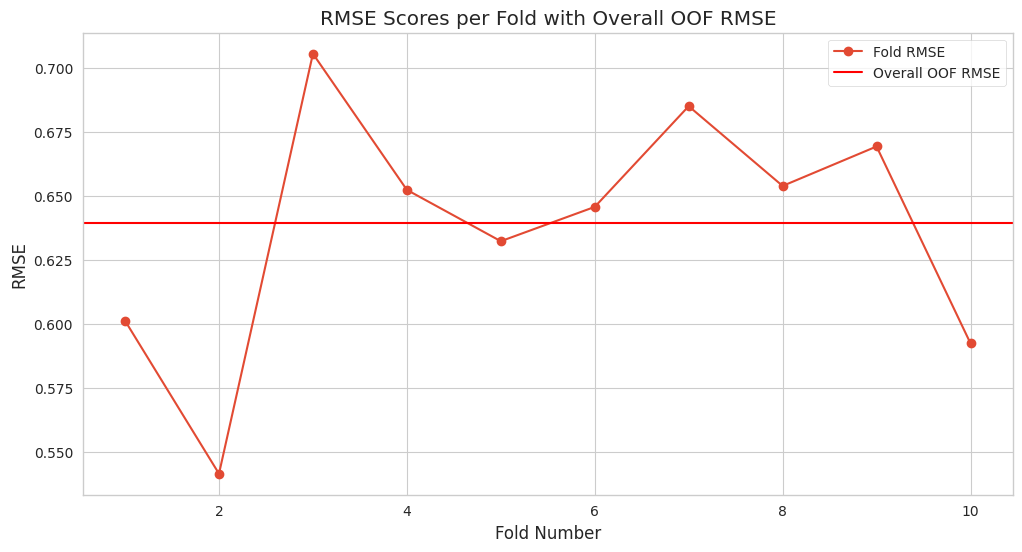

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics, model_selection
import matplotlib.pyplot as plt

# Initialize KFold object for cross-validation with 10 splits
kf = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)

# Prepare the test dataset using the selected feature columns.
X_test = test_feats[train_cols]
test_predict_list = []  # Initialize a list to store predictions on the test set from each fold.

models_dict = {}  # Initialize a dictionary to store models trained in each fold for later analysis or use.
fold_scores = []  # List to store the RMSE scores for each fold

# Loop through each fold, obtaining train and validation indices.
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
    print("="*50)
    print("Fold : ", fold)  # Print the current fold number for tracking progress.

    # Extract training and validation data using indices for the current fold.
    X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
    X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

    # Initialize the LightGBM model with specified parameters.
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 10000,
        "boosting_type": "gbdt",
        "seed": 42,
        'reg_alpha': 0.002333698391220378,
        'reg_lambda': 0.19122210526689265,
        'colsample_bytree': 0.5381228886377286,
        'subsample': 0.8921958229333354,
        'learning_rate': 0.01836065797320474,
        'num_leaves': 14,
        'min_child_samples': 66
    }
    model = lgb.LGBMRegressor(**params)

    # Fit the model to the training data, with early stopping based on validation data.
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(200, first_metric_only=True, verbose=False)])

    # Predict on the validation set and store these predictions for calculating OOF RMSE.
    valid_predict = model.predict(X_valid)
    oof_valid_preds[valid_idx] = valid_predict

    # Predict on the test set and append these predictions to the list for later averaging.
    test_predict = model.predict(X_test)
    test_predict_list.append(test_predict)

    # Calculate and print the RMSE score for the current fold's validation set.
    score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
    print("Fold RMSE Score : ", score)
    fold_scores.append(score)  # Store the RMSE score

    # Store the current fold's model in the dictionary using the fold number as the key.
    models_dict[fold] = model

# Calculate and print the overall OOF RMSE score after completing all folds.
oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
print("OOF RMSE Score : ", oof_score)

# Plotting RMSE scores for each fold and overall OOF RMSE
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), fold_scores, label='Fold RMSE', marker='o')
plt.axhline(y=oof_score, color='r', linestyle='-', label='Overall OOF RMSE')
plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.title('RMSE Scores per Fold with Overall OOF RMSE')
plt.legend()
plt.show()


In [ ]:
#Collect the feature importances from each model stored in the models_dict dictionary.
#The models_dict.values() gives us the models, from which we extract the feature_importances_ attribute.
#These are then converted into a NumPy array for easier manipulation. The mean of these importances
#is calculated across all folds (axis=0) to get the average importance of each feature.
feature_importances_values = np.asarray([model.feature_importances_ for model in models_dict.values()]).mean(axis=0)

#Create a DataFrame from the feature importances. This DataFrame has two columns:
#'name' containing the names of the features (from train_cols) and 'importance' containing
#the averaged importance values calculated in the previous step.
feature_importance_df = pd.DataFrame({'name': train_cols, 'importance': feature_importances_values})

#Sort the DataFrame by the 'importance' column in descending order. This means the most important features
#(i.e., those with the highest average importance values) will appear at the top of the DataFrame.
#Sorting by importance helps in quickly identifying which features contribute most to the model's predictions,
#which can be useful for feature selection, understanding model behavior, and communicating results.
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)


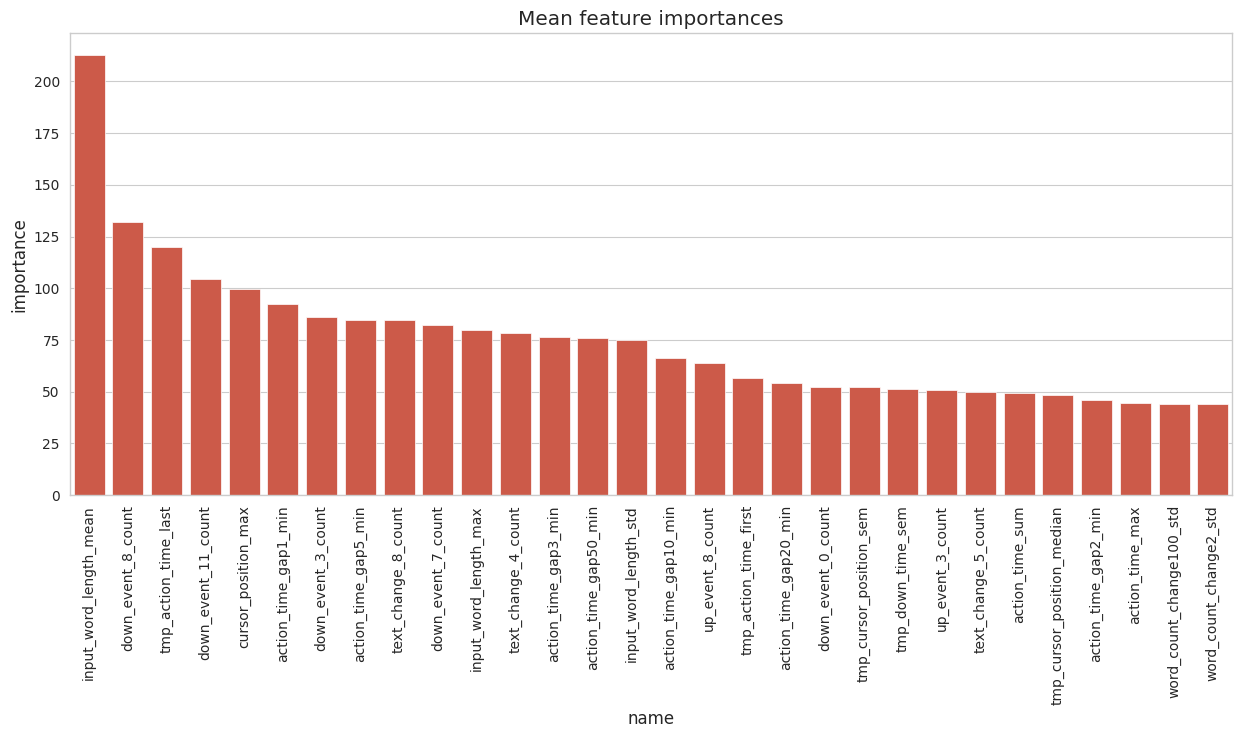

In [ ]:
#Set up a figure for plotting with a custom size to ensure the plot is large enough to be easily readable.
plt.figure(figsize=(15, 6))

#Use seaborn's barplot function to create a bar plot. The data argument specifies the source DataFrame,
#which is limited to the top 30 features by importance thanks to the prior sorting and head(30) operation.
#The 'x' argument is set to the 'name' column representing feature names, and 'y' to the 'importance' values.
#This plots a bar for each of the top 30 features, with the bar's length representing the feature's importance.
ax = sns.barplot(data=feature_importance_df.head(30), x='name', y='importance')

#Set the title of the plot to indicate what is being shown: the mean feature importances across all folds.
ax.set_title(f"Mean feature importances")

#Adjust the x-axis ticks to ensure that feature names are readable. This is done by setting the rotation to 90 degrees,
#which is particularly useful when dealing with a large number of features or long feature names that could overlap if displayed horizontally.
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

#Display the plot. This command renders the figure constructed above, showing the bar plot with the top 30 features ranked by importance.
plt.show()


In [ ]:
test_feats['score'] = np.mean(test_predict_list, axis=0)

In [ ]:
test_feats[['id', 'score']].to_csv("submission.csv", index=False)

In [ ]:
test_feats[['id', 'score']]

id     score
0  0000aaaa  1.447785
1  2222bbbb  1.400152
2  4444cccc  1.419738